# This notebook contains code to:


*   Reproduce the results from [Energy-Based Error Bound of Physics-Informed Neural Network Solutions in Elasticity, Mengwu Guo and Ehsan Haghighat, August 2022)](https://ascelibrary.org/doi/epdf/10.1061/%28ASCE%29EM.1943-7889.0002121)
*   Extend this approach to a Maxwell model of a viscoelastic body
*   Extend this approach to a Voigt model of a viscoelastic body




Promising examples: https://github.com/sciann/sciann-applications/tree/master/SciANN-ConstitutiveModeling

https://arxiv.org/abs/2203.09789

# Utility functions, installation and importing of modules - execute this cell first
From [sciann datagenerator.py](https://github.com/sciann/sciann-applications/tree/master/SciANN-Elasticity)


In [ ]:
pip install -U setuptools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.4.0 which is incompatible.


In [ ]:
pip install sciann

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 KB 53.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import sciann as sn
#dg = DataGeneratorXY([0.,1.], [0.,1.], num_sample=1000)
# dg.plot_data()

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.11.0 
Python Version: 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0] 



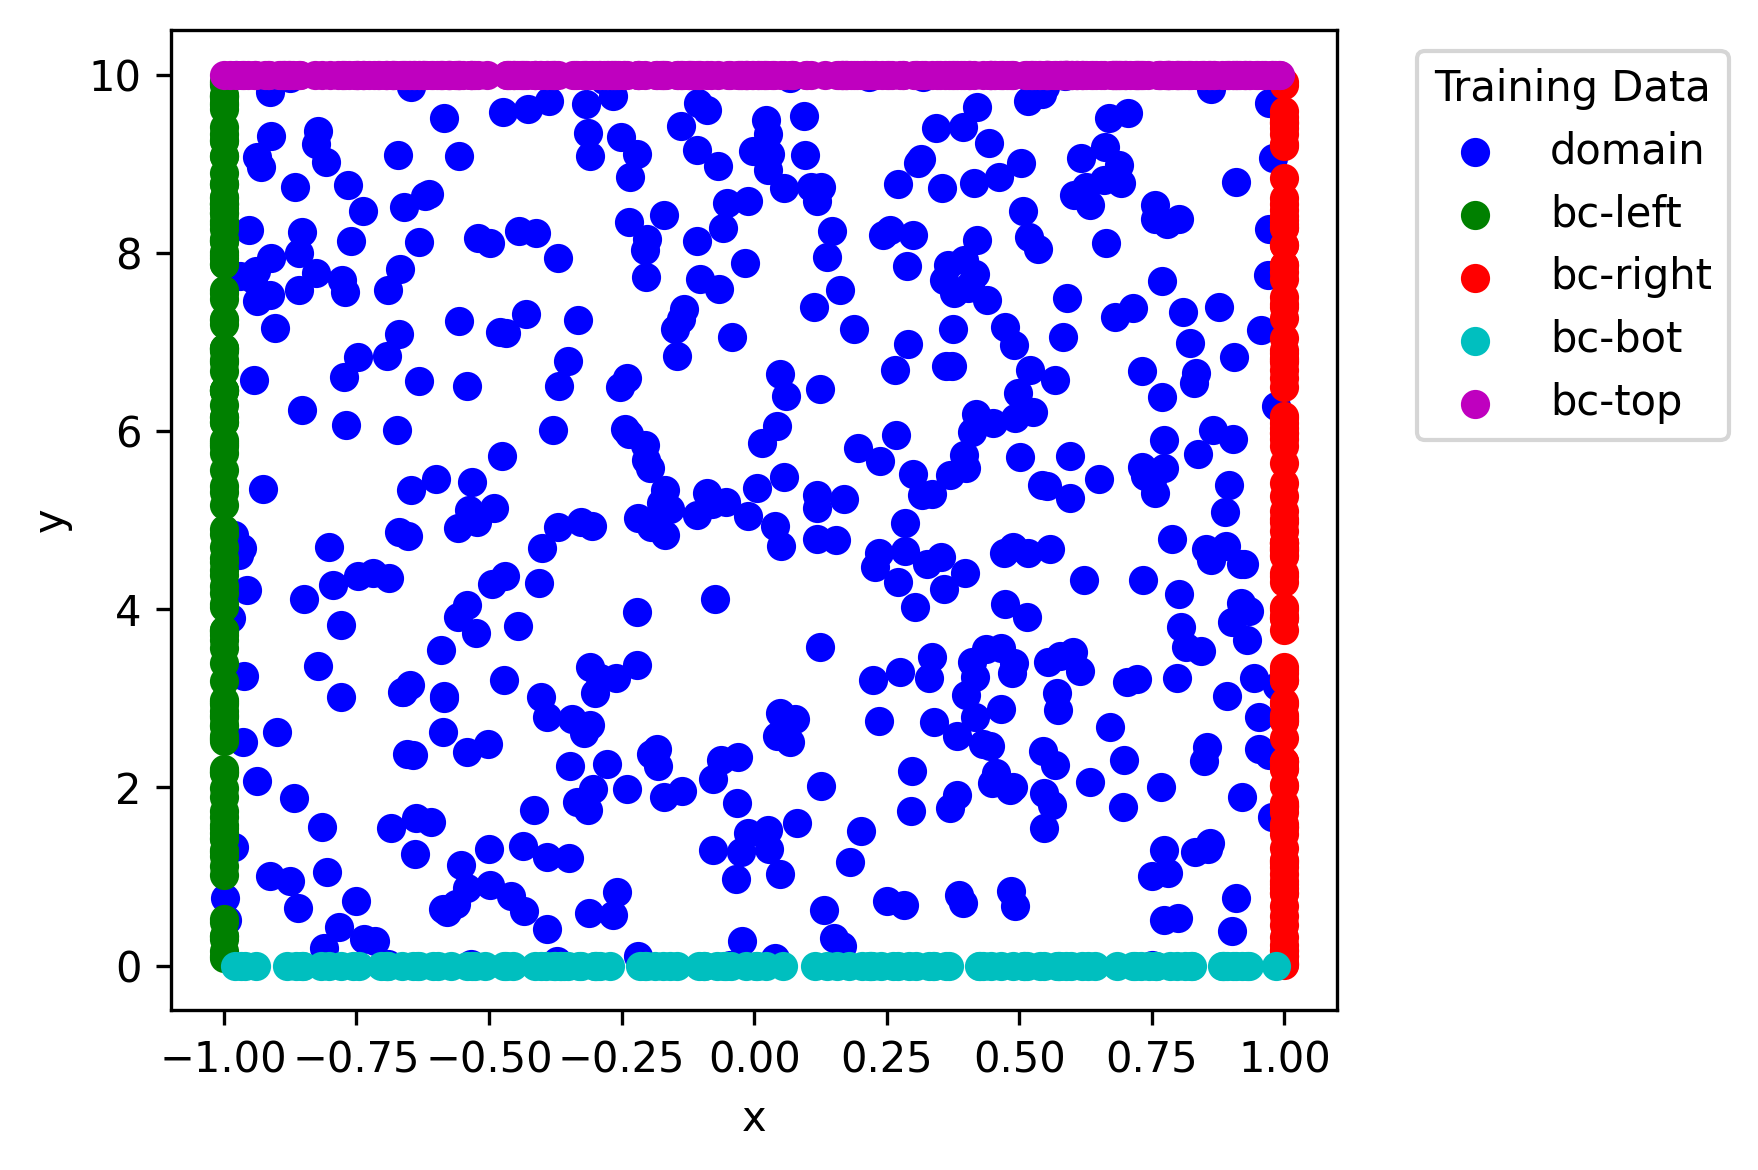

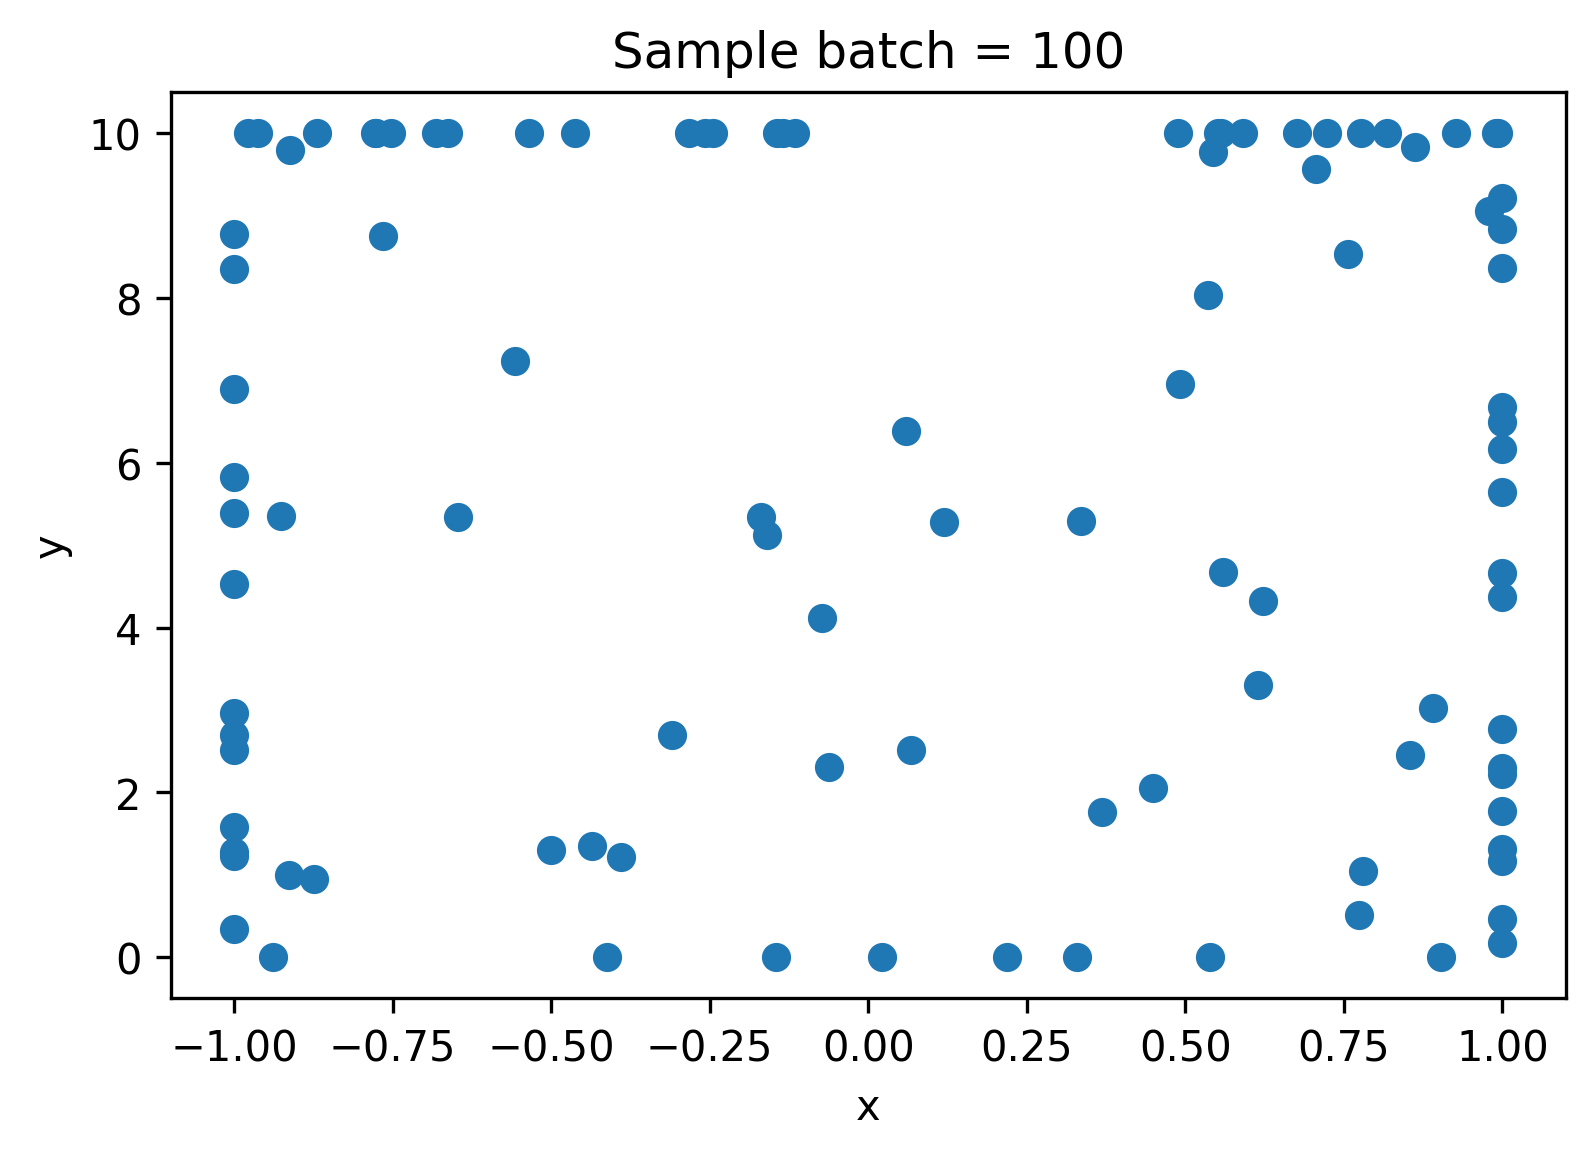

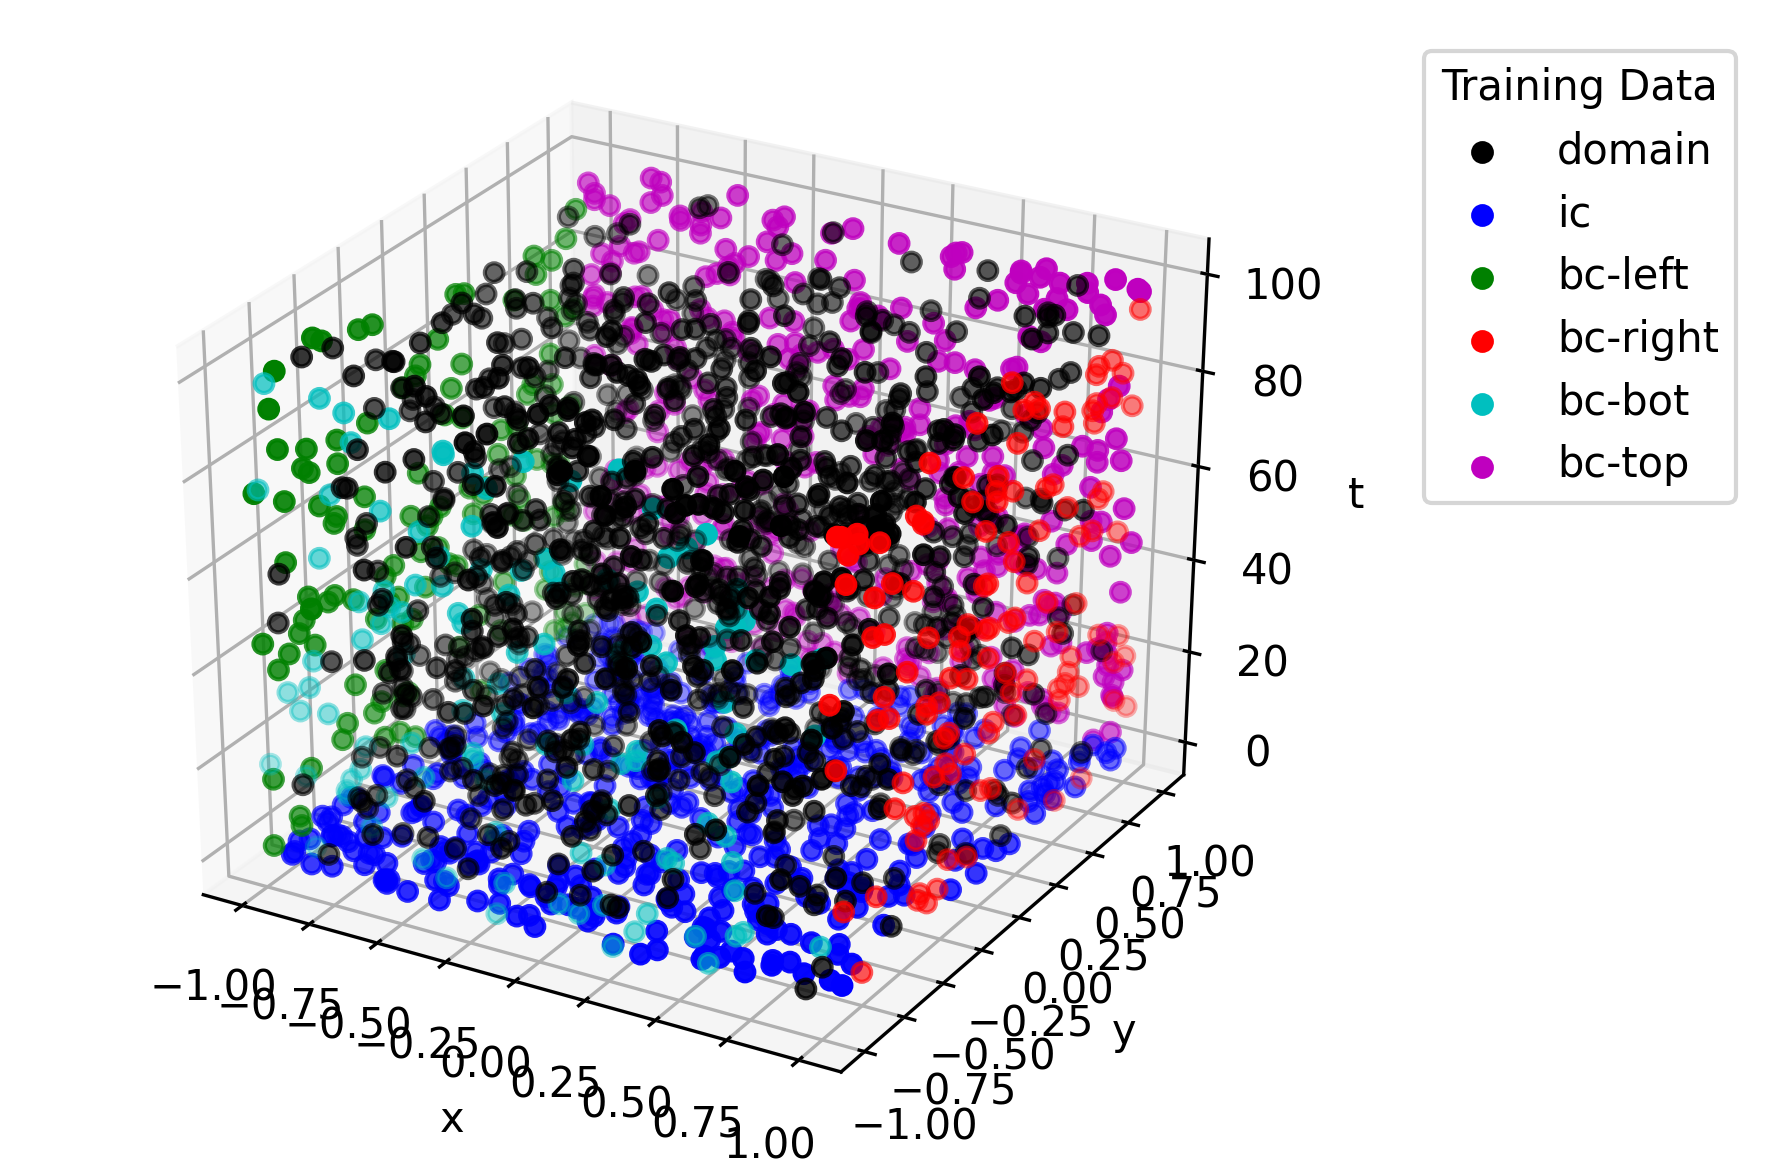

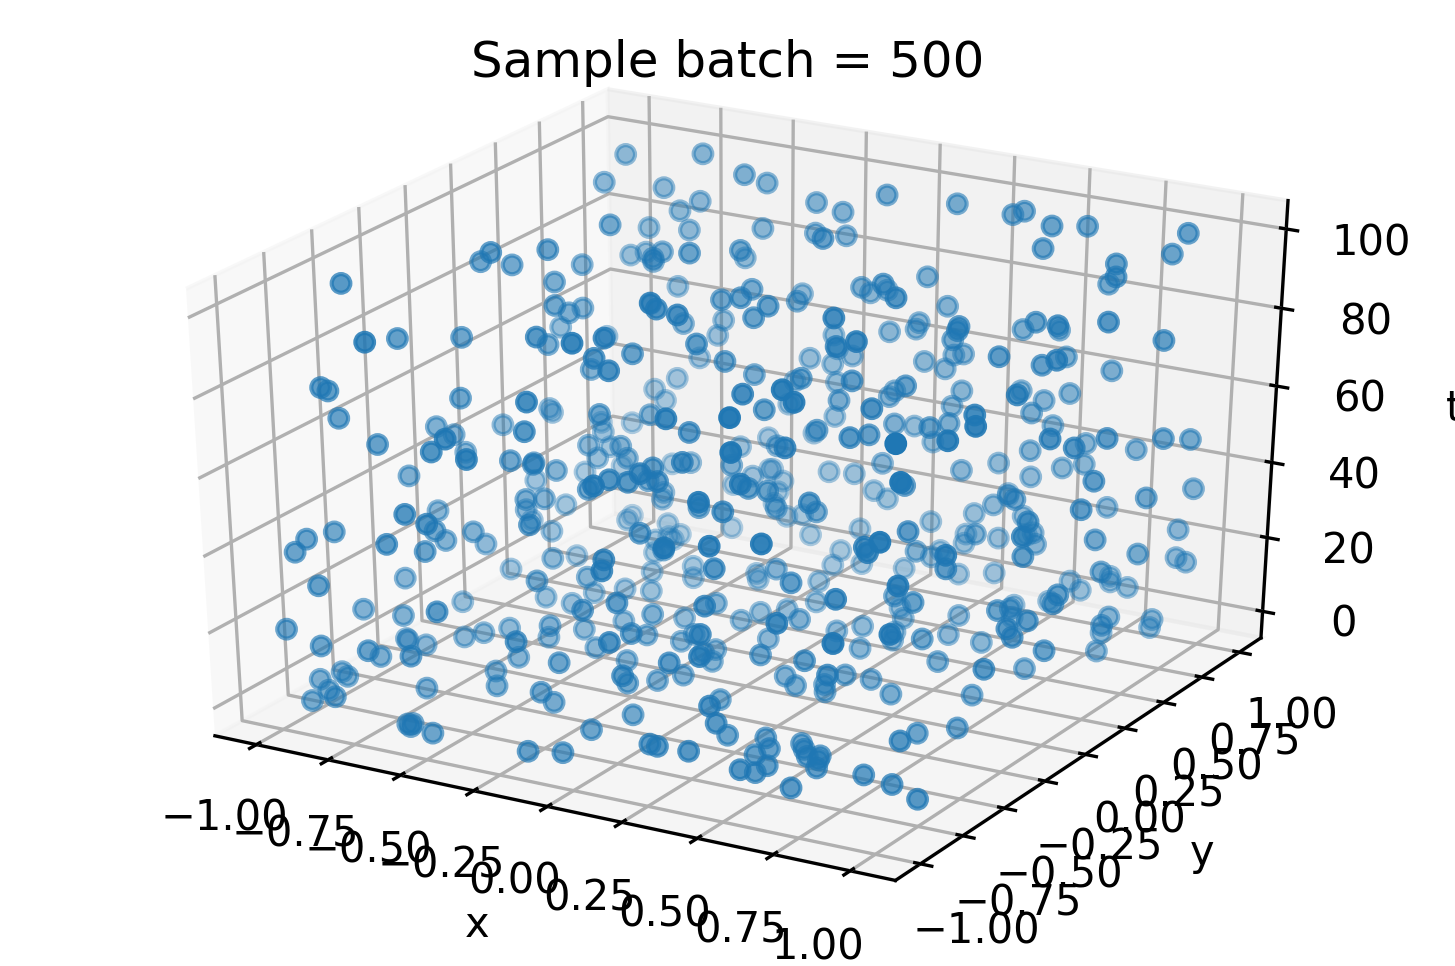

In [ ]:
# ==============================================================================
# Copyright 2021 SciANN -- Ehsan Haghighat.
# All Rights Reserved.
#
# Licensed under the MIT License.
#
# A guide for generating collocation points for PINN solvers.
#
# Includes:
#    - DataGeneratorX:
#           Generate 1D collocation grid.
#    - DataGeneratorXY:
#           Generate 2D collocation grid for a rectangular domain.
#    - DataGeneratorXT:
#           Generate 1D time-dependent collocation grid.
#    - DataGeneratorXYT:
#           Generate 2D time-dependent collocation grid  for a rectangular domain.
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle
cycol = cycle('bgrcmk')

plt.rcParams["figure.dpi"] = 300




class DataGeneratorX:
  """ Generates 1D collocation grid for training PINNs
  # Arguments:
    X: [X0, X1]
    targets: list and type of targets you wish to impose on PINNs.
        ('domain', 'bc-left', 'bc-right', 'all')
    num_sample: total number of collocation points.

  # Examples:
    >> dg = DataGeneratorX([0., 1.], ["domain", "bc-left", "bc-right"], 10000)
    >> input_data, target_data = dg.get_data()

  """
  def __init__(self,
               X=[0., 1.],
               targets=['domain', 'bc-left', 'bc-right'],
               num_sample=10000):
    'Initialization'
    self.Xdomain = X
    self.targets = targets
    self.num_sample = num_sample
    self.input_data = None
    self.target_data = None
    self.set_data()

  def __len__(self):
    return self.input_data[0].shape[0]

  def set_data(self):
    self.input_data, self.target_data = self.generate_data()

  def get_data(self):
    return self.input_data, self.target_data

  def generate_data(self):
    # distribute half inside domain half on the boundary
    num_sample = int(self.num_sample/2)

    counter = 0
    # domain points
    x_dom = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    ids_dom = np.arange(x_dom.shape[0])
    counter += ids_dom.size

    # left bc points
    x_bc_left = np.full(int(num_sample/2), self.Xdomain[0])
    ids_bc_left = np.arange(x_bc_left.shape[0]) + counter
    counter += ids_bc_left.size

    # right bc points
    x_bc_right = np.full(num_sample-int(num_sample/2), self.Xdomain[1])
    ids_bc_right = np.arange(x_bc_right.shape[0]) + counter
    counter += ids_bc_right.size

    ids_bc = np.concatenate([ids_bc_left, ids_bc_right])
    ids_all = np.concatenate([ids_dom, ids_bc])

    ids = {
        'domain': ids_dom,
        'bc-left': ids_bc_left,
        'bc-right': ids_bc_right,
        'bc': ids_bc,
        'all': ids_all
    }

    assert all([t in ids.keys() for t in self.targets]), \
      'accepted target types: {}'.format(ids.keys())

    input_data = [
        np.concatenate([x_dom, x_bc_left, x_bc_right]).reshape(-1,1),
    ]
    total_sample = input_data[0].shape[0]

    target_data = []
    for i, tp in enumerate(self.targets):
      target_data.append(
          (ids[tp], 'zeros')
      )

    return input_data, target_data

  def get_test_grid(self, Nx=1000):
    xs = np.linspace(self.Xdomain[0], self.Xdomain[1], Nx)
    return xs

  def plot_sample_batch(self, batch_size=500):
      ids = np.random.choice(len(self), batch_size, replace=False)
      x_data = self.input_data[0][ids,:]
      y_data = np.random.uniform(-.1, .1, x_data.shape)
      plt.scatter(x_data, y_data)
      plt.xlabel('x')
      plt.ylabel('Random vals')
      plt.ylim(-1,1)
      plt.title('Sample batch = {}'.format(batch_size))
      plt.show()

  def plot_data(self):
      fig = plt.figure()
      for t, (t_idx, t_val) in zip(self.targets, self.target_data):
        x_data = self.input_data[0][t_idx,:]
        y_data = np.random.uniform(-.1, .1, x_data.shape)
        plt.scatter(x_data, y_data, label=t, c=next(cycol))
      plt.ylim(-1,1)
      plt.xlabel('x')
      plt.ylabel('Random vals')
      plt.title('Training Data')
      plt.legend(title="Training Data", bbox_to_anchor=(1.05, 1), loc='upper left')
      fig.tight_layout()
      plt.show()


class DataGeneratorXY:
  """ Generates 2D collocation grid for a rectangular domain
  # Arguments:
    X: [X0, X1]
    Y: [Y0, Y1]
    targets: list and type of targets you wish to impose on PINNs.
        ('domain', 'bc-left', 'bc-right', 'bc-bot', 'bc-top', 'all')
    num_sample: total number of collocation points.

  # Examples:
    >> dg = DataGeneratorXY([0., 1.], [0., 1.], ["domain", "bc-left", "bc-right"], 10000)
    >> input_data, target_data = dg.get_data()

  """
  def __init__(self,
               X=[0., 1.],
               Y=[0., 1.],
               targets=['domain', 'bc-left', 'bc-right', 'bc-bot', 'bc-top'],
               num_sample=10000):
    'Initialization'
    self.Xdomain = X
    self.Ydomain = Y
    self.targets = targets
    self.num_sample = num_sample
    self.input_data = None
    self.target_data = None
    self.set_data()

  def __len__(self):
    return self.input_data[0].shape[0]

  def set_data(self):
    self.input_data, self.target_data = self.generate_data()

  def get_data(self):
    return self.input_data, self.target_data

  def generate_data(self):
    # distribute half inside domain half on the boundary
    num_sample = int(self.num_sample/2)

    counter = 0
    # domain points
    x_dom = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    y_dom = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample)
    ids_dom = np.arange(x_dom.shape[0])
    counter += ids_dom.size

    # bc points
    num_sample_per_edge = int(num_sample/4)
    # left bc points
    x_bc_left = np.full(num_sample_per_edge, self.Xdomain[0])
    y_bc_left = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample_per_edge)
    ids_bc_left = np.arange(x_bc_left.shape[0]) + counter
    counter += ids_bc_left.size

    # right bc points
    x_bc_right = np.full(num_sample_per_edge, self.Xdomain[1])
    y_bc_right = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample_per_edge)
    ids_bc_right = np.arange(x_bc_right.shape[0]) + counter
    counter += ids_bc_right.size

    # bot bc points
    x_bc_bot = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample_per_edge)
    y_bc_bot = np.full(num_sample_per_edge, self.Ydomain[0])
    ids_bc_bot = np.arange(x_bc_bot.shape[0]) + counter
    counter += ids_bc_bot.size

    # right bc points
    x_bc_top = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample-num_sample_per_edge)
    y_bc_top = np.full(num_sample-num_sample_per_edge, self.Ydomain[1])
    ids_bc_top = np.arange(x_bc_top.shape[0]) + counter
    counter += ids_bc_top.size

    ids_bc = np.concatenate([ids_bc_left, ids_bc_right, ids_bc_bot, ids_bc_top])
    ids_all = np.concatenate([ids_dom, ids_bc])

    ids = {
        'domain': ids_dom,
        'bc-left': ids_bc_left,
        'bc-right': ids_bc_right,
        'bc-bot': ids_bc_bot,
        'bc-top': ids_bc_top,
        'bc': ids_bc,
        'all': ids_all
    }

    assert all([t in ids.keys() for t in self.targets]), \
      'accepted target types: {}'.format(ids.keys())

    input_data = [
        np.concatenate([x_dom, x_bc_left, x_bc_right, x_bc_bot, x_bc_top]).reshape(-1,1),
        np.concatenate([y_dom, y_bc_left, y_bc_right, y_bc_bot, y_bc_top]).reshape(-1,1),
    ]
    total_sample = input_data[0].shape[0]

    target_data = []
    for i, tp in enumerate(self.targets):
      target_data.append(
          (ids[tp], 'zeros')
      )

    return input_data, target_data

  def get_test_grid(self, Nx=200, Ny=200):
    xs = np.linspace(self.Xdomain[0], self.Xdomain[1], Nx)
    ys = np.linspace(self.Ydomain[0], self.Ydomain[1], Ny)
    input_data, target_data = np.meshgrid(xs, ys)
    return [input_data, target_data]

  def plot_sample_batch(self, batch_size=500):
      ids = np.random.choice(len(self), batch_size, replace=False)
      x_data = self.input_data[0][ids,:]
      y_data = self.input_data[1][ids,:]
      plt.scatter(x_data, y_data)
      plt.xlabel('x')
      plt.ylabel('y')
      plt.title('Sample batch = {}'.format(batch_size))
      plt.show()

  def plot_data(self):
      fig = plt.figure()
      for t, (t_idx, t_val) in zip(self.targets, self.target_data):
        x_data = self.input_data[0][t_idx,:]
        y_data = self.input_data[1][t_idx,:]
        plt.scatter(x_data, y_data, label=t, c=next(cycol))
      plt.xlabel('x')
      plt.ylabel('y')
      plt.legend(title="Training Data", bbox_to_anchor=(1.05, 1), loc='upper left')
      fig.tight_layout()
      plt.show()


class DataGeneratorXT:
  """ Generates 1D time-dependent collocation grid for training PINNs
  # Arguments:
    X: [X0, X1]
    T: [T0, T1]
    targets: list and type of targets you wish to impose on PINNs.
        ('domain', 'ic', 'bc-left', 'bc-right', 'all')
    num_sample: total number of collocation points.
    logT: generate random samples logarithmic in time.

  # Examples:
    >> dg = DataGeneratorXT([0., 1.], [0., 1.], ["domain", "ic", "bc-left", "bc-right"], 10000)
    >> input_data, target_data = dg.get_data()

  """
  def __init__(self,
               X=[0., 1.],
               T=[0., 1.],
               targets=['domain', 'ic', 'bc-left', 'bc-right'],
               num_sample=10000,
               logT=False):
    'Initialization'
    self.Xdomain = X
    self.Tdomain = T
    self.logT = logT
    self.targets = targets
    self.num_sample = num_sample
    self.input_data = None
    self.target_data = None
    self.set_data()

  def __len__(self):
    return self.input_data[0].shape[0]

  def set_data(self):
    self.input_data, self.target_data = self.generate_data()

  def get_data(self):
    return self.input_data, self.target_data

  def generate_uniform_T_samples(self, num_sample):
    if self.logT is True:
      t_dom = np.random.uniform(np.log1p(self.Tdomain[0]), np.log1p(self.Tdomain[1]), num_sample)
      t_dom = np.exp(t_dom) - 1.
    else:
      t_dom = np.random.uniform(self.Tdomain[0], self.Tdomain[1], num_sample)
    return t_dom

  def generate_data(self):
    # Half of the samples inside the domain.
    num_sample = int(self.num_sample/2)

    counter = 0
    # domain points
    x_dom = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    t_dom = self.generate_uniform_T_samples(num_sample)
    ids_dom = np.arange(x_dom.shape[0])
    counter += ids_dom.size

    # The other half distributed equally between BC and IC.
    num_sample = int(self.num_sample/4)

    # initial conditions
    x_ic = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    t_ic = np.full(num_sample, self.Tdomain[0])
    ids_ic = np.arange(x_ic.shape[0]) + counter
    counter += ids_ic.size

    # bc points
    num_sample_per_edge = int(num_sample/2)
    # left bc points
    x_bc_left = np.full(num_sample_per_edge, self.Xdomain[0])
    t_bc_left = self.generate_uniform_T_samples(num_sample_per_edge)
    ids_bc_left = np.arange(x_bc_left.shape[0]) + counter
    counter += ids_bc_left.size

    # right bc points
    x_bc_right = np.full(num_sample-num_sample_per_edge, self.Xdomain[1])
    t_bc_right = self.generate_uniform_T_samples(num_sample-num_sample_per_edge)
    ids_bc_right = np.arange(x_bc_right.shape[0]) + counter
    counter += ids_bc_right.size

    ids_bc = np.concatenate([ids_bc_left, ids_bc_right])
    ids_all = np.concatenate([ids_dom, ids_ic, ids_bc])

    ids = {
        'domain': ids_dom,
        'bc-left': ids_bc_left,
        'bc-right': ids_bc_right,
        'ic': ids_ic,
        'bc': ids_bc,
        'all': ids_all
    }

    assert all([t in ids.keys() for t in self.targets]), \
      'accepted target types: {}'.format(ids.keys())

    input_data = [
        np.concatenate([x_dom, x_ic, x_bc_left, x_bc_right]).reshape(-1,1),
        np.concatenate([t_dom, t_ic, t_bc_left, t_bc_right]).reshape(-1,1),
    ]
    total_sample = input_data[0].shape[0]

    target_data = []
    for i, tp in enumerate(self.targets):
      target_data.append(
          (ids[tp], 'zeros')
      )

    return input_data, target_data

  def get_test_grid(self, Nx=200, Nt=200):
    xs = np.linspace(self.Xdomain[0], self.Xdomain[1], Nx)
    if self.logT:
      ts = np.linspace(np.log1p(self.Tdomain[0]), np.log1p(self.Tdomain[1]), Nt)
      ts = np.exp(ts) - 1.0
    else:
      ts = np.linspace(self.Tdomain[0], self.Tdomain[1], Nt)
    return np.meshgrid(xs, ts)

  def plot_sample_batch(self, batch_size=500):
      ids = np.random.choice(len(self), batch_size, replace=False)
      x_data = self.input_data[0][ids,:]
      t_data = self.input_data[1][ids,:]
      plt.scatter(x_data, t_data)
      plt.xlabel('x')
      plt.ylabel('t')
      plt.title('Sample batch = {}'.format(batch_size))
      plt.show()

  def plot_data(self):
      fig = plt.figure()
      for t, (t_idx, t_val) in zip(self.targets, self.target_data):
        x_data = self.input_data[0][t_idx,:]
        t_data = self.input_data[1][t_idx,:]
        plt.scatter(x_data, t_data, label=t, c=next(cycol))
      plt.xlabel('x')
      plt.ylabel('t')
      plt.legend(title="Training Data", bbox_to_anchor=(1.05, 1), loc='upper left')
      fig.tight_layout()
      plt.show()


class DataGeneratorXYT:
  """ Generates 2D time-dependent collocation grid for training PINNs
  # Arguments:
    X: [X0, X1]
    Y: [Y0, Y1]
    T: [T0, T1]
    targets: list and type of targets you wish to impose on PINNs.
        ('domain', 'ic', 'bc-left', 'bc-right', 'bc-bot', 'bc-top', 'all')
    num_sample: total number of collocation points.
    logT: generate random samples logarithmic in time.

  # Examples:
    >> dg = DataGeneratorXYT([0., 1.], [0., 1.], [0., 1.],
                             ["domain", "ic", "bc-left", "bc-right", "bc-bot", "bc-top"],
                             10000)
    >> input_data, target_data = dg.get_data()

  """
  def __init__(self,
               X=[0., 1.],
               Y=[0., 1.],
               T=[0., 1.],
               targets=['domain', 'ic', 'bc-left', 'bc-right', 'bc-bot', 'bc-top'],
               num_sample=10000,
               logT=False):
    'Initialization'
    self.Xdomain = X
    self.Ydomain = Y
    self.Tdomain = T
    self.logT = logT
    self.targets = targets
    self.num_sample = num_sample
    self.input_data = None
    self.target_data = None
    self.set_data()

  def __len__(self):
    return self.input_data[0].shape[0]

  def set_data(self):
    self.input_data, self.target_data = self.generate_data()

  def get_data(self):
    return self.input_data, self.target_data

  def generate_uniform_T_samples(self, num_sample):
    if self.logT is True:
      t_dom = np.random.uniform(np.log1p(self.Tdomain[0]), np.log1p(self.Tdomain[1]), num_sample)
      t_dom = np.exp(t_dom) - 1.
    else:
      t_dom = np.random.uniform(self.Tdomain[0], self.Tdomain[1], num_sample)
    return t_dom

  def generate_data(self):
    # Half of the samples inside the domain.
    num_sample = int(self.num_sample/2)

    counter = 0
    # domain points
    x_dom = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    y_dom = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample)
    t_dom = self.generate_uniform_T_samples(num_sample)
    ids_dom = np.arange(x_dom.shape[0])
    counter += ids_dom.size

    # The other half distributed equally between BC and IC.
    num_sample = int(self.num_sample/4)

    # initial conditions
    x_ic = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    y_ic = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample)
    t_ic = np.full(num_sample, self.Tdomain[0])
    ids_ic = np.arange(x_ic.shape[0]) + counter
    counter += ids_ic.size

    # bc points
    num_sample_per_edge = int(num_sample/4)
    # left bc points
    x_bc_left = np.full(num_sample_per_edge, self.Xdomain[0])
    y_bc_left = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample_per_edge)
    t_bc_left = self.generate_uniform_T_samples(num_sample_per_edge)
    ids_bc_left = np.arange(x_bc_left.shape[0]) + counter
    counter += ids_bc_left.size

    # right bc points
    x_bc_right = np.full(num_sample_per_edge, self.Xdomain[1])
    y_bc_right = np.random.uniform(self.Ydomain[0], self.Ydomain[1], num_sample_per_edge)
    t_bc_right = self.generate_uniform_T_samples(num_sample_per_edge)
    ids_bc_right = np.arange(x_bc_right.shape[0]) + counter
    counter += ids_bc_right.size

    # bot bc points
    x_bc_bot = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample_per_edge)
    y_bc_bot = np.full(num_sample_per_edge, self.Ydomain[0])
    t_bc_bot = self.generate_uniform_T_samples(num_sample_per_edge)
    ids_bc_bot = np.arange(x_bc_bot.shape[0]) + counter
    counter += ids_bc_bot.size

    # right bc points
    x_bc_top = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample-num_sample_per_edge)
    y_bc_top = np.full(num_sample-num_sample_per_edge, self.Ydomain[1])
    t_bc_top = self.generate_uniform_T_samples(num_sample-num_sample_per_edge)
    ids_bc_top = np.arange(x_bc_top.shape[0]) + counter
    counter += ids_bc_top.size

    ids_bc = np.concatenate([ids_bc_left, ids_bc_right, ids_bc_bot, ids_bc_top])
    ids_all = np.concatenate([ids_dom, ids_ic, ids_bc])

    ids = {
        'domain': ids_dom,
        'bc-left': ids_bc_left,
        'bc-right': ids_bc_right,
        'bc-bot': ids_bc_bot,
        'bc-top': ids_bc_top,
        'ic': ids_ic,
        'bc': ids_bc,
        'all': ids_all
    }

    assert all([t in ids.keys() for t in self.targets]), \
      'accepted target types: {}'.format(ids.keys())

    input_grid = [
        np.concatenate([x_dom, x_ic, x_bc_left, x_bc_right, x_bc_bot, x_bc_top]).reshape(-1,1),
        np.concatenate([y_dom, y_ic, y_bc_left, y_bc_right, y_bc_bot, y_bc_top]).reshape(-1,1),
        np.concatenate([t_dom, t_ic, t_bc_left, t_bc_right, t_bc_bot, t_bc_top]).reshape(-1,1),
    ]
    total_sample = input_grid[0].shape[0]

    target_grid = []
    for i, tp in enumerate(self.targets):
      target_grid.append(
          (ids[tp], 'zeros')
      )

    return input_grid, target_grid

  def get_test_grid(self, Nx=50, Ny=50, Nt=100):
    xs = np.linspace(self.Xdomain[0], self.Xdomain[1], Nx)
    ys = np.linspace(self.Ydomain[0], self.Ydomain[1], Ny)
    if self.logT:
      ts = np.linspace(np.log1p(self.Tdomain[0]), np.log1p(self.Tdomain[1]), Nt)
      ts = np.exp(ts) - 1.0
    else:
      ts = np.linspace(self.Tdomain[0], self.Tdomain[1], Nt)
    return np.meshgrid(xs, ys, ts)

  def plot_sample_batch(self, batch_size=500):
      ids = np.random.choice(len(self), batch_size, replace=False)
      x_data = self.input_data[0][ids,:]
      y_data = self.input_data[1][ids,:]
      t_data = self.input_data[2][ids,:]
      fig = plt.figure()
      ax = fig.add_subplot(projection='3d')
      ax.scatter(x_data, y_data, t_data)
      ax.set_xlabel('x')
      ax.set_ylabel('y')
      ax.set_zlabel('t')
      plt.title('Sample batch = {}'.format(batch_size))
      plt.show()

  def plot_data(self):
      fig = plt.figure()
      ax = fig.add_subplot(projection='3d')
      for t, (t_idx, t_val) in zip(self.targets, self.target_data):
        x_data = self.input_data[0][t_idx,:]
        y_data = self.input_data[1][t_idx,:]
        t_data = self.input_data[2][t_idx,:]
        ax.scatter(x_data, y_data, t_data, label=t, c=next(cycol))
      ax.set_xlabel('x')
      ax.set_ylabel('y')
      ax.set_zlabel('t')
      plt.legend(title="Training Data", bbox_to_anchor=(1.05, 1), loc='upper left')
      fig.tight_layout()
      plt.show()


def ex1():
    dg = DataGeneratorX(
        X=[-1., 1.],
        targets=['domain', 'bc-left', 'bc-right'],
        num_sample=1000
    )
    dg.plot_data()
    dg.plot_sample_batch(100)

def ex2():
    dg = DataGeneratorXY(
        X=[-1., 1.],
        Y=[0., 10.],
        targets=['domain', 'bc-left', 'bc-right', 'bc-bot', 'bc-top'],
        num_sample=1000
    )
    dg.plot_data()
    dg.plot_sample_batch(100)

def ex3():
    dg = DataGeneratorXT(
        X=[-1., 1.],
        T=[0., 100.],
        targets=['domain', 'ic', 'bc-left', 'bc-right'],
        num_sample=1000,
        logT=False
    )
    dg.plot_data()
    dg.plot_sample_batch(100)

def ex4():
    dg = DataGeneratorXYT(
        X=[-1., 1.],
        Y=[-1., 1.],
        T=[0., 100.],
        targets=['domain', 'ic', 'bc-left', 'bc-right', 'bc-bot', 'bc-top'],
        num_sample=2000,
        logT=False
    )
    dg.plot_data()
    dg.plot_sample_batch(500)


if __name__=='__main__':
  # ex1()
  ex2()
  # ex3()
  ex4()



# Model problem of linear elasticity

Consider an elastic body whose undeformed configuration $X$ is defined in the domain:  

$\Omega \subset \mathbb{R}^d (d = 1, 2, 3)$
<br>

with a Lipschitz boundary
$\Gamma = \Gamma_D \cup \Gamma_N$ \\
With the Dirichlet boundary
$\Gamma_D \neq \emptyset$, \\
and the Neumann boundary
$\Gamma_D \cap \Gamma_N = \emptyset$.
<br>
<br>
The elastic body is subject to:
*   a prescribed body force $ f \in  [L^2 (\Omega)]^d$ in $\Omega$ (with respect to the undeformed volume)
*   a prescribed displacement $u_D$ on $\Gamma_D$
*   and a prescribed surface force of density
$t \in [L^2(\Gamma_N)]^d$ (with respect to the undeformed surface area.)
<br>
<br>

## Aim:
We are seeking a solution to the vector field of displacements \\
$u: \Omega \to \mathbb{R}^d$
<br>
and the stress tensor field \\
$\sigma: \Omega \to \mathbb{R}^{d \times d}$
<br>
that satisfies the continutity of the displacement field $u$
<br>
$u \in [H_1(\Omega)]^d$
<br>
and the Dirichlet boundary condition
<br>
$u = u_D$ on $\Gamma_D$.
<br>
that also satisfies the following equilibrium conditions:
<br>
the momentum equation
<br>
$div \, \sigma + f = 0$  
and the Neumann boundary condition.
<br>
in $\Omega, \sigma  \, n = t$ on $\Gamma_N$
<br>
<br>
This vector field must also satisfy the elastic constitutive relation:
<br>
$\sigma = \mathcal{C}[\nabla u]$.
<br>
<br>
Where $\mathcal{C}: \mathbb{R}^{d \times d} \to \mathbb{R}^{d \times d}$ is a constitutive relation which maps the displacement gradient $\nabla u$ to the stress tensor $\sigma$.





# Physics informed neural network (PINN) approach

We use **five** neural networks to approximate the components:
* the displacement field $u$
<br>
$u(X) ≈ u^{NN}(X) = \bigg[\begin{matrix} u_x^{NN} \\ u_y^{NN} \end{matrix} \bigg]$
<br>
<br>
* the stress field $\sigma$
<br>
$\sigma(X) ≈ \sigma^{NN}(X) = \bigg[ \begin{matrix} \sigma_{xx}^{NN} \sigma_{xy}^{NN} \\ \sigma_{yx}^{NN} \sigma_{yy}^{NN} \end{matrix}\bigg]$

Note that in linear elasticity the shear components of the stress are equal $\sigma_{xy} = \sigma_{yx}$

These neural networks are trained with a by minimising a loss function $\mathcal{L}$ which is the sum

$\mathcal{L} = MSE_{\,\Gamma_D} + MSE_{f} + MSE_{\,\Gamma_N} + \eta MSE_{\,\mathcal{C}} + \alpha(MSE_{u} + MSE_{\sigma})$

of the following mean squared error (MSE) equations
<br>


\begin{align}
       MSE_{\,\Gamma_D} &= \frac{1}{N_{\Gamma_D}} \sum_{k=1}^{N_{\Gamma_D}} ||u^{NN}(X_{k}\vert_{\Gamma_D}; \theta - u_D (X_k \vert_{\Gamma_D})||^2_2 \\
       MSE_{f} &= \frac{1}{N_{\Omega}} \sum_{k=1}^{N_\Omega} || div \sigma^{NN} (X_{k} \vert_{\Omega}) + f(X_{K} \vert_{\Omega} ||^2_F \\
       MSE_{\,\Gamma_N} &= \frac{1}{N_{\Gamma_N}} \sum_{k=1}^{N_{\Gamma_N}} ||\sigma^{NN} (X_{k} \vert_{\Gamma_N}) n - t(X_{k} \vert_{\Gamma_N}) ||^2_2\\
       MSE_{,\mathcal{C}} &= \frac{1}{N_{\Omega}} \sum_{k=1}^{N_\Omega} || \sigma^{NN} (X_{K} \vert_{\Omega} - \mathcal{C} \big[∇u^{NN}(X_{k} \vert_\Omega) || ^2_2  \\
       MSE_{u} &= \frac{1}{N_{\Omega}} \sum_{k=1}^{N_\Omega} || u^{NN} (X_{k} \vert_\Omega) - u(X_{k} \vert_\Omega) ||^2_2\\
       MSE_{\sigma} &= \frac{1}{N_{\Omega}} \sum_{k=1}^{N_\Omega} || \sigma^{NN} (X_{k}\vert_\Omega) - \sigma(X_{k}\vert_\Omega) ||^2_F
    \end{align}



Where
${X_1 \vert_\Omega, ..., X_{N_\Omega} \vert_\Omega}$,
are the collocation points over the domain $\Omega$
<br>
and ${X_1 \vert_{\Gamma_N}, ..., X_{N_{\Gamma_N}} \vert_{\Gamma_N}}$
are the collocation points over the boundaries $\Gamma_N$ and $\Gamma_D$
<br>
$\eta \in \mathbb{R}^+$ is a penalty coefficient for imposing the constitutive equation
$\alpha$ is a binary variable, $\alpha = 0$ gives a pure boundary value problem and $\alpha = 1$ is the full PINN problem, which considers the enhancement given by collocation data of $u$ and $\sigma$ over $\Omega$, i.e. the loss function gives a physics informed regression with the PDE constrains given by the boundary and bulk(?) force

# Forward problem

First we consider the case where $\alpha = 0$, i.e. where PINNs are being used a solver of the boundary value problem given by eqs (i.e. the physics part)

The domain is a square plate defined as $\Omega = [0,1]^2$ with unit side length $L_x = L_y = 1$


In [ ]:
dg = DataGeneratorXY(X=[0.,1.], Y=[0.,1.],
                     num_sample=10000, #change back to 10000
                     targets=5*['domain'] + 2*['bc-left'] + 2*['bc-right'] + 2*['bc-bot'] + 2*['bc-top'])

input_data, target_data = dg.get_data()

The square plate has sides


$\Gamma_{x{^-}} = \{X = (x,y)^T\vert x=0, y \in [0,1]\}$
<br>
$\Gamma_{x{^+}} = \{X = (x,y)^T\vert x=1, y \in [0,1]\}$
<br>
$\Gamma_{y{^-}} = \{X = (x,y)^T\vert y=0, x \in [0,1]\}$
<br>
$\Gamma_{y{^+}} = \{X = (x,y)^T\vert y=1, x \in [0,1]\}$
<br>

the domain is subjected to the boundary conditions:
  <br>
  $\sigma_{xx} = 0$
  <br>
  $u_y = 0$
  <br>
  on $\Gamma_x^-$ and $\Gamma_x^+$


  <br>
  $u_x = u_y = 0$ on $\Gamma_y^-$
  <br>
  $u_x = 0$
  <br>
  $\sigma_{yy} = (\lambda + 2\mu)Q \, sin(\pi x)$ on $\Gamma_y^+$

  Where $\lambda$ and $\mu$ are two Lamé parameters of a homogenous and isotropic material. Additionally in Guo and Haghighat (2022), $Q=4$.


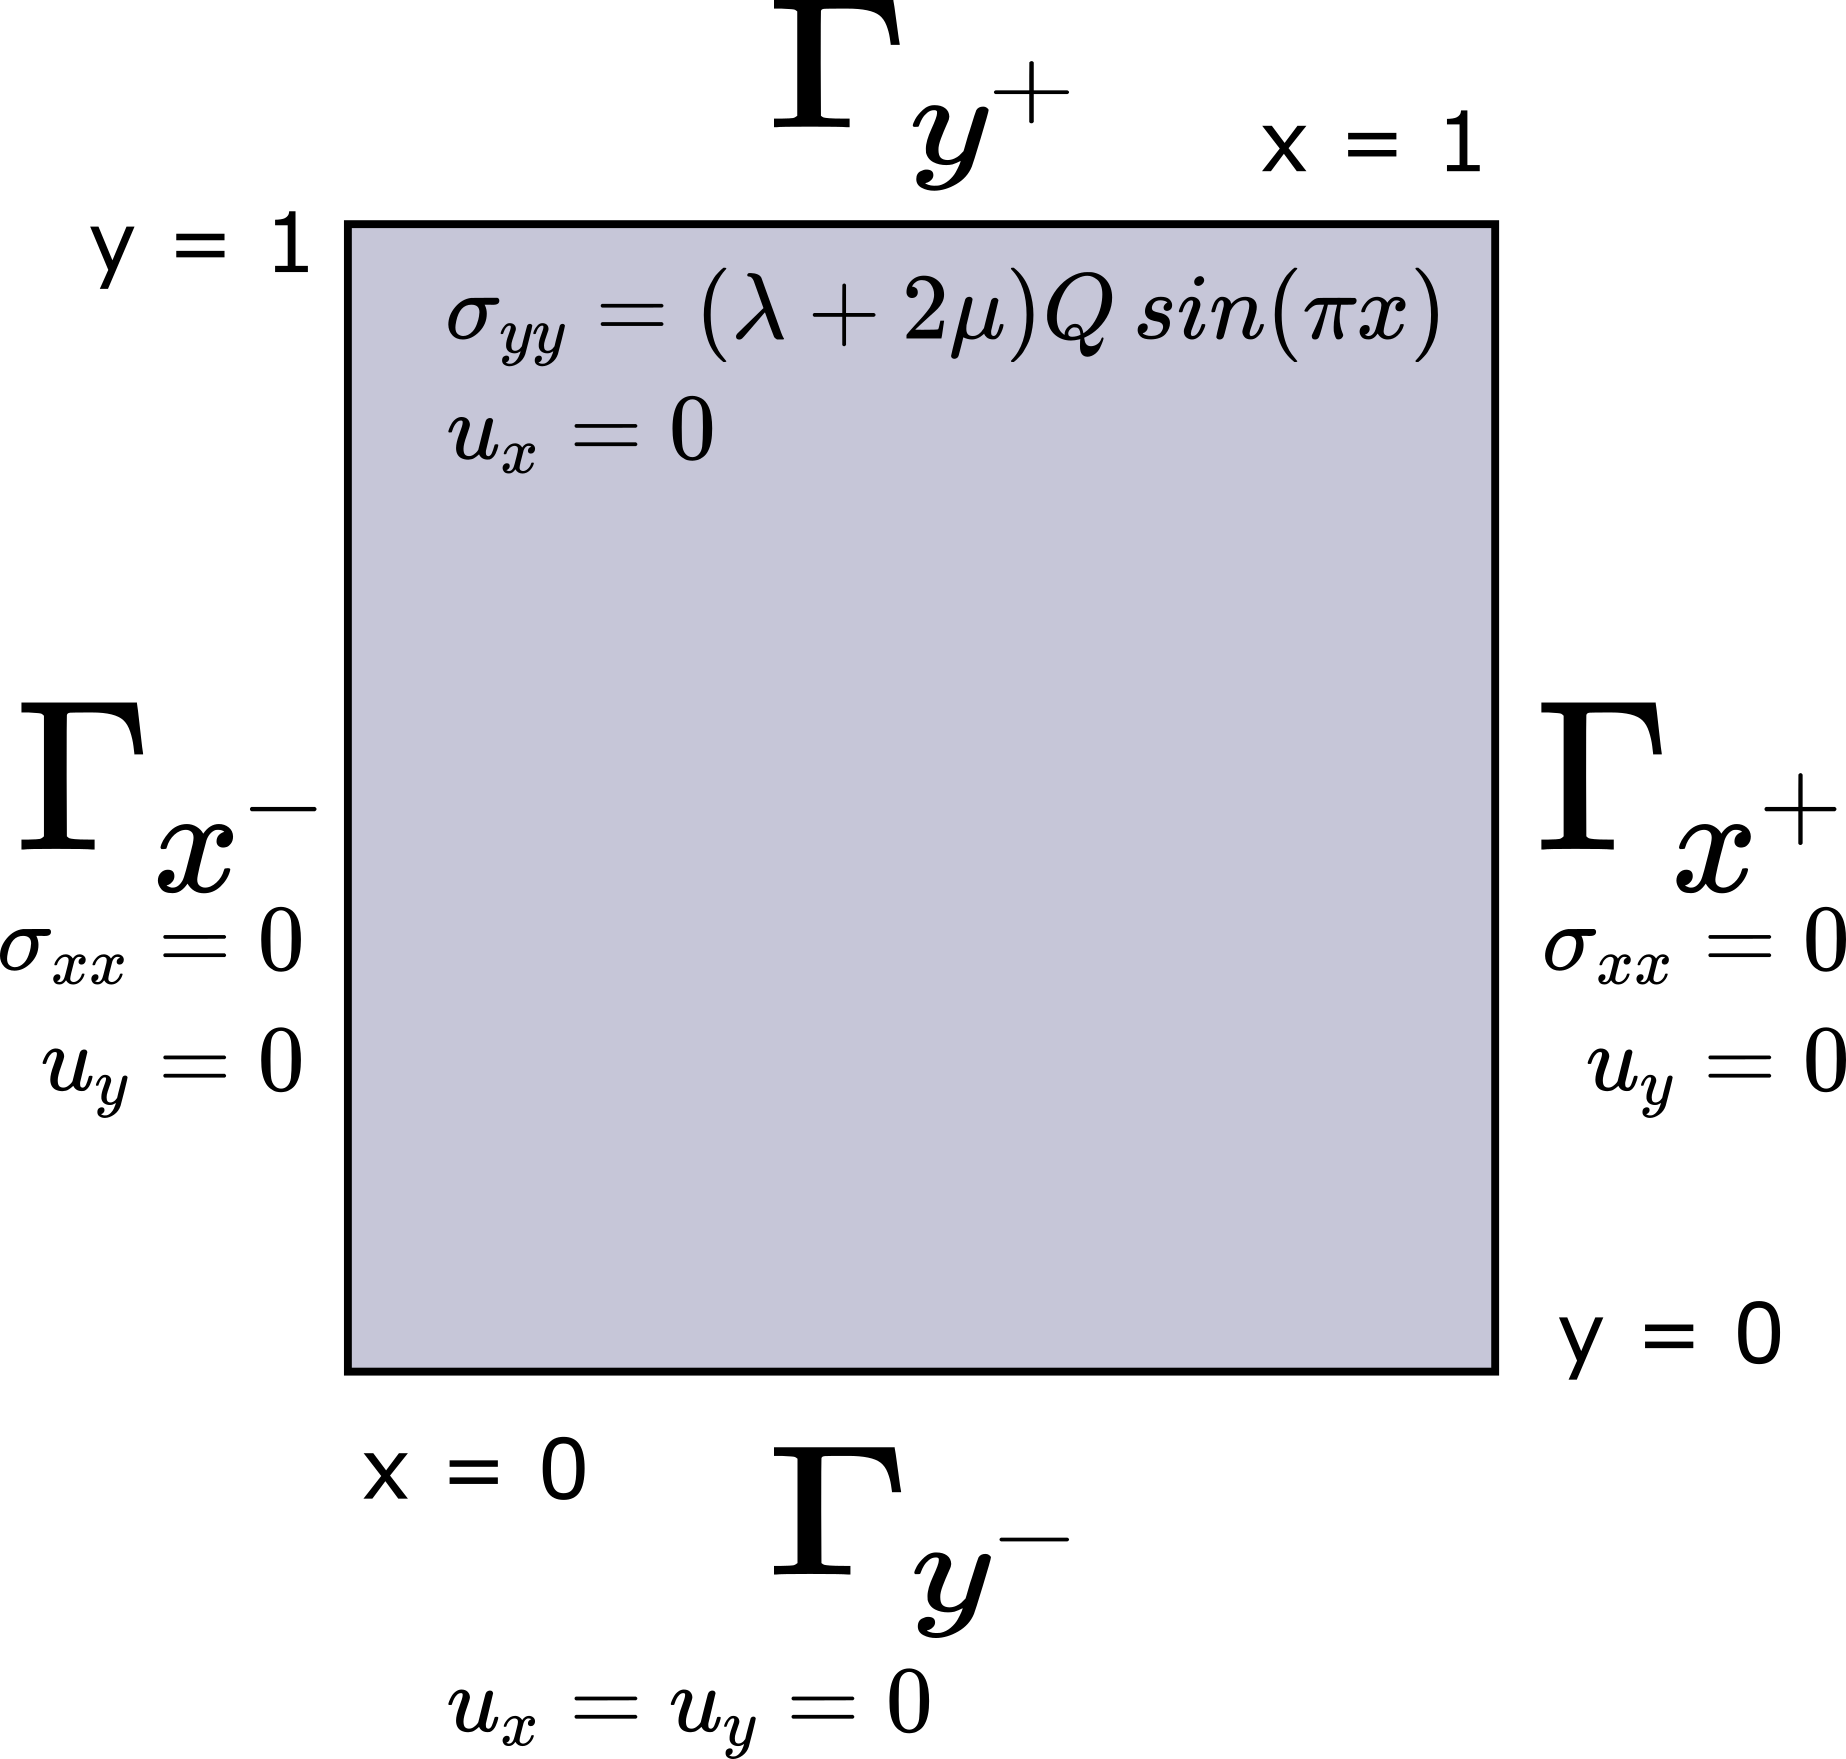![linear_elasticity_2d_domain_bcs.png]()

In [ ]:
# Lame parameters of a homogenous and isotropic material
lmbd = 1.0
# shear modulus
mu = 0.5
# 'we took Q = 4'
Q = 4.0


(Possibly useful) Recall that
Given a value for both $\lambda$ and $\mu$ (AKA G) we can calculate the other elastic moduli:
<br>
Bulk modulus $K = \lambda + \mu$
<br>
Youngs modulus $E = \frac{4*\mu(\lambda+\mu)}{\lambda+2*\mu}$
<br>
poissons ratio $\nu = \frac{\lambda}{\lambda + 2*\mu}$
<br>
P-wave modulus $M = \lambda + 2*\mu$

We first define our inputs to the network using

```
sn.variable
```
we need a separate variable for each dimension of our problem.


In [ ]:
dtype='float32'

x = sn.Variable("x", dtype=dtype)
y = sn.Variable("y", dtype=dtype)

Next initialise neural networks for the x and y components of the displacement field $u$ using ```sn.Functional```

<br>
<br>
$u(X) ≈ u^{NN}(X) = \bigg[\begin{matrix} u_x^{NN} \\ u_y^{NN} \end{matrix} \bigg]$

In [ ]:
# Neural network for the displacement U in x/y
# TODO increase network size for more accuracy: e.g. 8*[100]
# a NN with inputs [x,y], 4 hidden layers of 40 size, tanh activation function
Uxy = sn.Functional("Uxy", [x, y], 4*[40], 'tanh')

# Neural network for the displacement V in x/y
Vxy = sn.Functional("Vxy", [x, y], 4*[40], 'tanh')


And the components of the stress field
$\sigma$
<br>
<br>
$\sigma(X) ≈ \sigma^{NN}(X) = \bigg[ \begin{matrix} \sigma_{xx}^{NN} \sigma_{xy}^{NN} \\ \sigma_{yx}^{NN} \sigma_{yy}^{NN} \end{matrix}\bigg]$

In [ ]:
#neural networks for the pressure component of the stress
Sxx = sn.Functional("Sxx", [x, y], 4*[40], 'tanh')
Syy = sn.Functional("Syy", [x, y], 4*[40], 'tanh')

# Neural network for the shear forces, in linear elasticity
# S_xy = S_yx hence just one here
Sxy = sn.Functional("Sxy", [x, y], 4*[40], 'tanh')

The strains are obtained from the gradients of the displacement networks, and the output of this is a neural network of the same size as the displacement network.

e.g.

$\epsilon_{xx} \approx \epsilon_{xx}^{NN}= \frac{\partial u_{xy}^{NN}}{\partial x} $

In [ ]:
# strains
Exx = sn.diff(Uxy, x) # discrete differences in Uxy - ASSUMING this is the same as np.diff
Eyy = sn.diff(Vxy, y)
Exy = (sn.diff(Uxy, y) + sn.diff(Vxy, x))*0.5


The following comprises the 'Physics-informed' part of the neural network setup.

First, constitutive relations for linear elasticity are defined

\begin{aligned}
\sigma_{xx} &= (\lambda + 2\mu) ϵ_{xx} + \lambda \epsilon_{yy} \\
\sigma_{yy} &= (\lambda + 2\mu) ϵ_{yy} + \lambda \epsilon_{xx} \\
\sigma_{xy} &= \lambda \epsilon_{xy}
\end{aligned}

In [ ]:
# Possibly constitutive relations # TODO change this to a maxwell model
C11 = (2*mu + lmbd) # P-wave/shear modulus?
C12 = lmbd #
C33 = 2*mu #


c1 = sn.Tie(Sxx, Exx*C11 + Eyy*C12) # sn.tie constrains networks outputs i.e. ensures cond1 (Sxx) - cond2 (Exx*C11 + Eyy*C12) = 0(?)
c2 = sn.Tie(Syy, Eyy*C11 + Exx*C12)
c3 = sn.Tie(Sxy, Exy*C33)

# Forces acting on the body
Fx = - lmbd*(4*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - mu*(pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - 8*mu*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y)

   # equilibrium equations for the stress if you subsitute the constitutive eq
   # so you can write it in terms of the strain - you end up with an equation which you
   # know can be solved by fourier series which involves sins and cosines

Fy = lmbd*(3*Q*y**2*sn.sin(pi*x) - 2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x)) \
   - mu*(2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x) + (Q*y**4*pi**2*sn.sin(pi*x))/4) \
   + 6*Q*mu*y**2*sn.sin(pi*x)

# Losses
Lx = sn.diff(Sxx, x) + sn.diff(Sxy, y) - Fx # do_xx/dx + do_xy/dy + f_x = 0
Ly = sn.diff(Sxy, x) + sn.diff(Syy, y) - Fy # do_xy/dx + doyy/dy + f_y = 0

BC_left_1 = (x==0.)*(Vxy) # vertical displacement = 0
BC_left_2 = (x==0.)*Sxx #o_xx is 0 here as well
# V/U xy is V/U AT x/y
BC_right_1 = (x==1.)*(Vxy) # same as for left
BC_right_2 = (x==1.)*Sxx

BC_bot_1 = (y==0.)*(Uxy) #fixed boundary condition
BC_bot_2 = (y==0.)*(Vxy) #no horizontal or vertical displacement

BC_top_1 = (y==1.)*(Uxy) #fixed in horizontal
BC_top_2 = (y==1.)*(Syy - (lmbd+2*mu)*Q*sn.sin(pi*x)) #fixed stress boundary cd

# collecting the losses

targets = [Lx, Ly, c1, c2, c3,
           BC_left_1, BC_left_2,
           BC_right_1, BC_right_2,
           BC_bot_1, BC_bot_2,
           BC_top_1, BC_top_2]

In [ ]:
# dg = DataGeneratorXY(X=[0.,1.], Y=[0.,1.],
#                      num_sample=10000, #change back to 10000
#                      targets=5*['domain'] + 2*['bc-left'] + 2*['bc-right'] + 2*['bc-bot'] + 2*['bc-top'])

# input_data, target_data = dg.get_data()

In [ ]:
m = sn.SciModel([x, y], targets)

In [ ]:
m.train(input_data, target_data, batch_size=100, epochs=500)


Total samples: 12500 
Batch size: 100 
Total batches: 125 

Epoch 1/500
125/125 [==============================] - 4s 30ms/step - batch: 62.0000 - size: 100.0000 - loss: 2.2726 - sub_10_loss: 1.2256 - sub_11_loss: 0.4709 - sub_loss: 0.2111 - sub_2_loss: 0.1346 - sub_3_loss: 0.0274 - mul_49_loss: 0.0021 - mul_50_loss: 0.0273 - mul_51_loss: 0.0033 - mul_52_loss: 0.0925 - mul_53_loss: 0.0026 - mul_54_loss: 0.0025 - mul_55_loss: 0.0081 - mul_58_loss: 0.0646 - lr: 0.0010 - time: 3.7439
Epoch 2/500
125/125 [==============================] - 4s 32ms/step - batch: 62.0000 - size: 100.0000 - loss: 1.1757 - sub_10_loss: 0.7296 - sub_11_loss: 0.1815 - sub_loss: 0.1020 - sub_2_loss: 0.0585 - sub_3_loss: 0.0124 - mul_49_loss: 0.0012 - mul_50_loss: 0.0085 - mul_51_loss: 0.0029 - mul_52_loss: 0.0460 - mul_53_loss: 0.0018 - mul_54_loss: 0.0025 - mul_55_loss: 0.0057 - mul_58_loss: 0.0232 - lr: 0.0010 - time: 3.9850
Epoch 3/500
125/125 [==============================] - 4s 31ms/step - batch: 62.0000 - 

In [ ]:
x_test, y_test = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))

In [ ]:
u_test = Uxy.eval([x_test, y_test])
v_test = Vxy.eval([x_test, y_test])
sxx_test = Sxx.eval([x_test, y_test])
syy_test = Syy.eval([x_test, y_test])
sxy_test = Sxy.eval([x_test, y_test])
Fx_test = Fx.eval([x_test, y_test])
Fy_test = Fy.eval([x_test, y_test])
exx_test = Exx.eval([x_test, y_test])
eyy_test = Eyy.eval([x_test, y_test])
exy_test = Exy.eval([x_test, y_test])

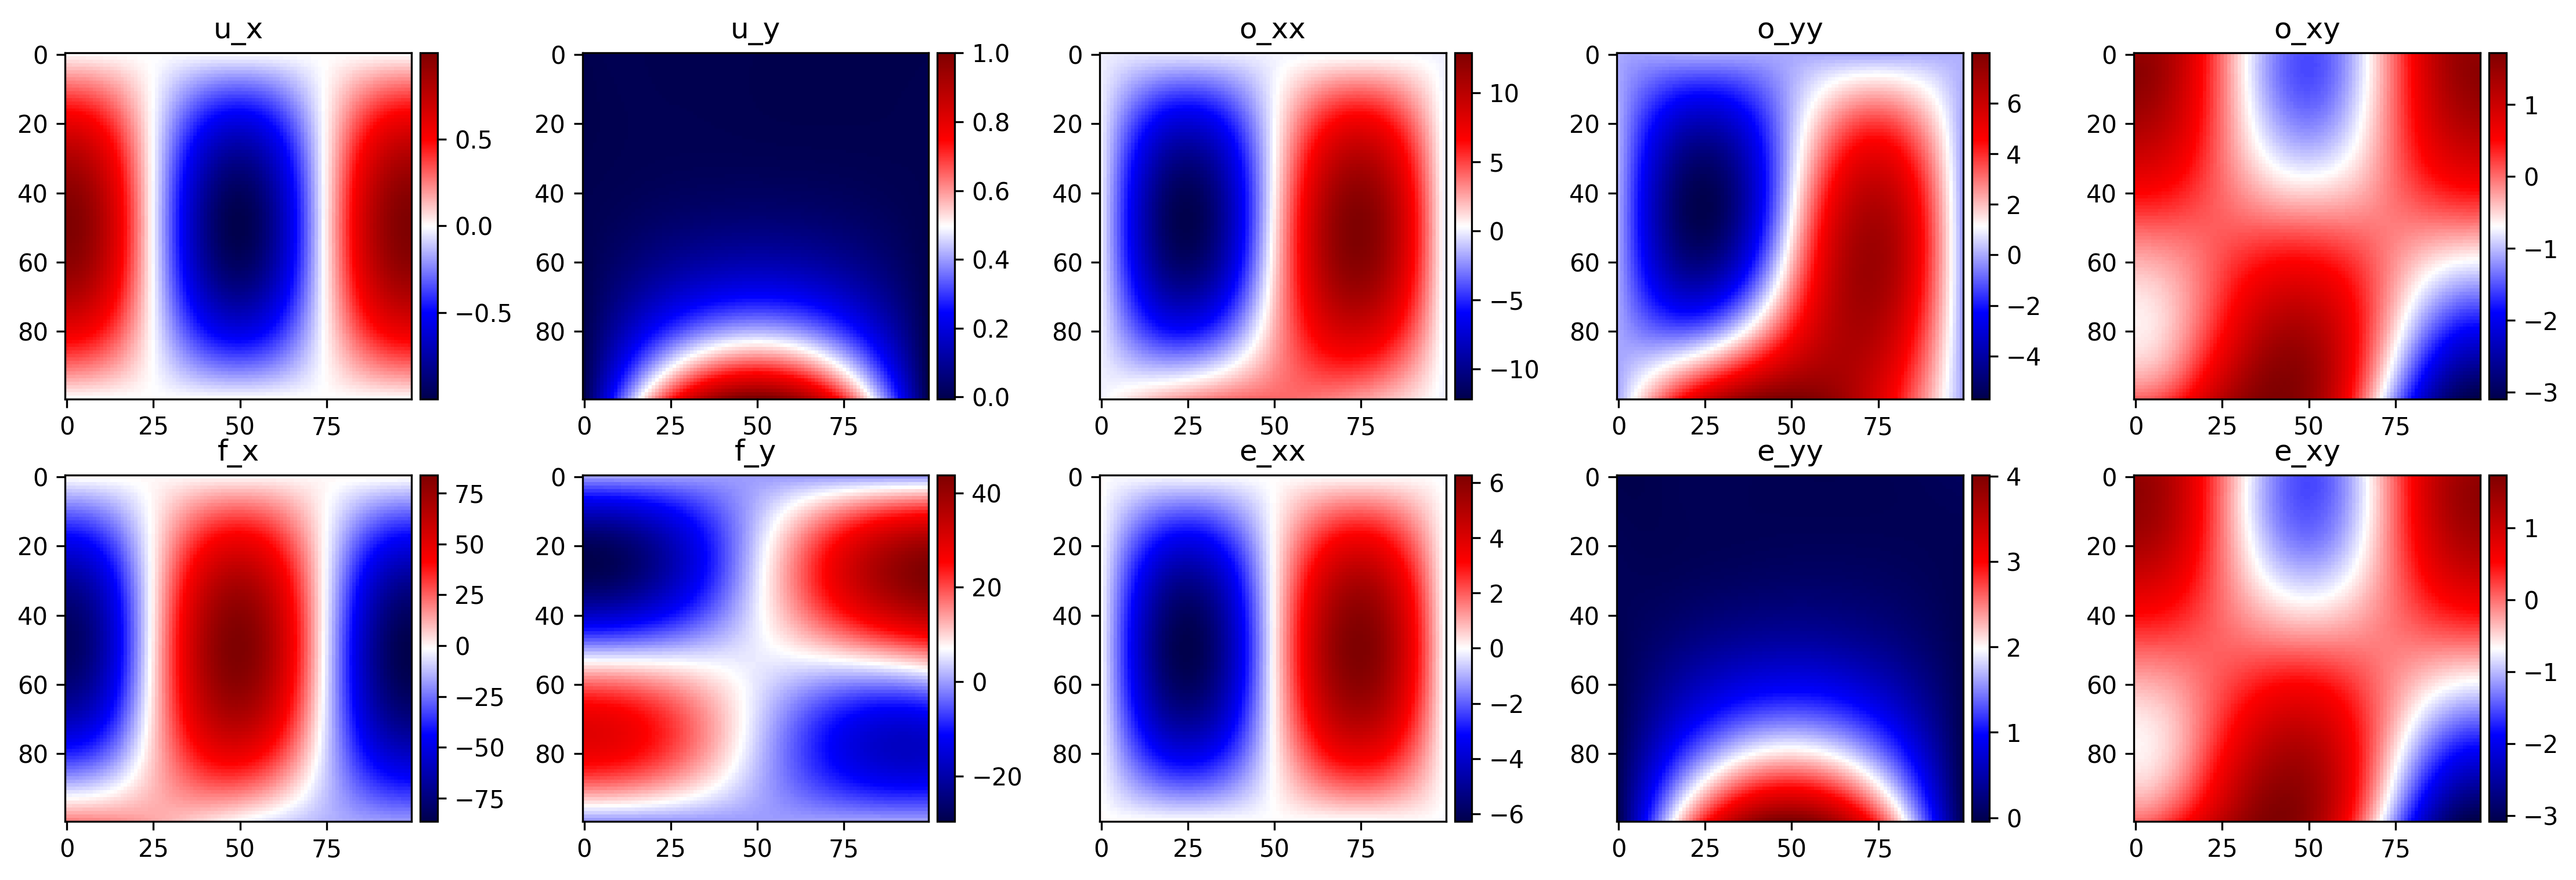

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
tests = [u_test, v_test, sxx_test, syy_test, sxy_test, Fx_test, Fy_test, exx_test, eyy_test, exy_test]
titles = ['u_x', 'u_y', 'o_xx','o_yy','o_xy','f_x','f_y', 'e_xx','e_yy','e_xy']
rows, cols = 2,5
fig,ax = plt.subplots(rows,cols,figsize=(15,5), dpi=300)


plt.tight_layout(pad=1.05)
n=0
for i in range(rows):
  for j in range(cols):
    ax[i][j].set_aspect('equal')
    ax[i][j].set_title('{}'.format(titles[n]))
    divider = make_axes_locatable(ax[i][j])
    cax = divider.append_axes("right", size="5%", pad = 0.05)
    im = ax[i][j].imshow(tests[n], cmap='seismic')
    plt.colorbar(im, cax = cax)
    n+=1

# Inverse problem

In [ ]:
Q = 4.0

In [ ]:
# Neural Network Setup.
dtype='float32'

x = sn.Variable("x", dtype=dtype)
y = sn.Variable("y", dtype=dtype)

Uxy = sn.Functional("Uxy", [x, y], 4*[40], 'tanh')
Vxy = sn.Functional("Vxy", [x, y], 4*[40], 'tanh')

# Sxx = sn.Functional("Sxx", [x, y], 4*[40], 'tanh')
# Syy = sn.Functional("Syy", [x, y], 4*[40], 'tanh')
# Sxy = sn.Functional("Sxy", [x, y], 4*[40], 'tanh')

lmbd = sn.Parameter(np.random.rand(), name='lmbd', inputs=[x,y])
mu = sn.Parameter(np.random.rand(), name='mu', inputs=[x,y])

C11 = (2*mu + lmbd)
C12 = lmbd
C33 = 2*mu

# Strains
Exx = sn.diff(Uxy, x)
Eyy = sn.diff(Vxy, y)
Exy = (sn.diff(Uxy, y) + sn.diff(Vxy, x))*0.5

# c1 = sn.Tie(Sxx, Exx*C11 + Eyy*C12)
# c2 = sn.Tie(Syy, Eyy*C11 + Exx*C12)
# c3 = sn.Tie(Sxy, Exy*C33)

# the difference here between this and the forward model is that the strains are used to infer the stresses

Sxx= Exx*C11 + Eyy*C12
Syy= Eyy*C11 + Exx*C12
Sxy= Exy*C33

# body forces specified
Fx = - 1.*(4*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - 0.5*(pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - 0.5*8*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y)

Fy = 1.0*(3*Q*y**2*sn.sin(pi*x) - 2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x)) \
   - 0.5*(2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x) + (Q*y**4*pi**2*sn.sin(pi*x))/4) \
   + 0.5*6*Q*y**2*sn.sin(pi*x)

Lx = sn.diff(Sxx, x) + sn.diff(Sxy, y) - Fx
Ly = sn.diff(Sxy, x) + sn.diff(Syy, y) - Fy

# sn.Data
Du = sn.Data(Uxy)
Dv = sn.Data(Vxy)


targets = [Lx, Ly, Du, Dv]

In [ ]:
m = sn.SciModel([x, y], targets)

In [ ]:
#generate data - collocation?
x_data, y_data = np.meshgrid(np.linspace(0.,1.,20), np.linspace(0., 1., 20))

#prescribed displacement everywhere (including at the boundary)
u_data = np.cos(2*pi*x_data) * np.sin(pi*y_data)
v_data = np.sin(pi*x_data) * Q * y_data**4/4
# syy_data = 2*Q*np.sin(pi*y_data)*(y_data==1.)

Lx_data = np.zeros_like(x_data)
Ly_data = np.zeros_like(y_data)

c1_data = np.zeros_like(y_data)
c2_data = np.zeros_like(y_data)
c3_data = np.zeros_like(y_data)

In [ ]:
h = m.train([x_data, y_data], [Lx_data, Ly_data, u_data, v_data], #syy_data],
            batch_size=50, epochs=500, log_parameters={'parameters':[lmbd, mu], 'freq':1},
            adaptive_weights={'method':'NTK', 'freq': 100})


Total samples: 400 
Batch size: 50 
Total batches: 8 


+ NTK evaluation time [s]: 4.448761463165283 

+ adaptive_weights at epoch 1: [0.16494370255547103, 0.12781162576558572, 2.065438210027856, 1.641806461651088]
Epoch 1/500
8/8 [==============================] - 12s 200ms/step - batch: 3.5000 - size: 50.0000 - loss: 324.8884 - sub_23_loss: 1770.8406 - sub_24_loss: 250.6424 - Uxy_loss: 0.2976 - Vxy_loss: 0.0912 - lr: 0.0010 - time: 24.7153 - loss_weight_0: 0.1649 - loss_weight_1: 0.1278 - loss_weight_2: 2.0654 - loss_weight_3: 1.6418 - loss_gradient_0: 7358.3916 - loss_gradient_1: 15983.0346 - loss_gradient_2: 202.8136 - loss_gradient_3: 259.0173 - lmbd: 0.6847 - mu: 0.9613
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - batch: 3.5000 - size: 50.0000 - loss: 301.6652 - sub_23_loss: 1667.4650 - sub_24_loss: 202.8047 - Uxy_loss: 0.2509 - Vxy_loss: 0.1146 - lr: 0.0010 - time: 0.1069 - loss_weight_0: 0.1649 - loss_weight_1: 0.1278 - loss_weight_2: 2.0654 - loss_weight_

In [ ]:
h.history.keys()

dict_keys(['loss', 'sub_23_loss', 'sub_24_loss', 'Uxy_loss', 'Vxy_loss', 'lr', 'time', 'loss_weight_0', 'loss_weight_1', 'loss_weight_2', 'loss_weight_3', 'loss_gradient_0', 'loss_gradient_1', 'loss_gradient_2', 'loss_gradient_3', 'lmbd', 'mu'])

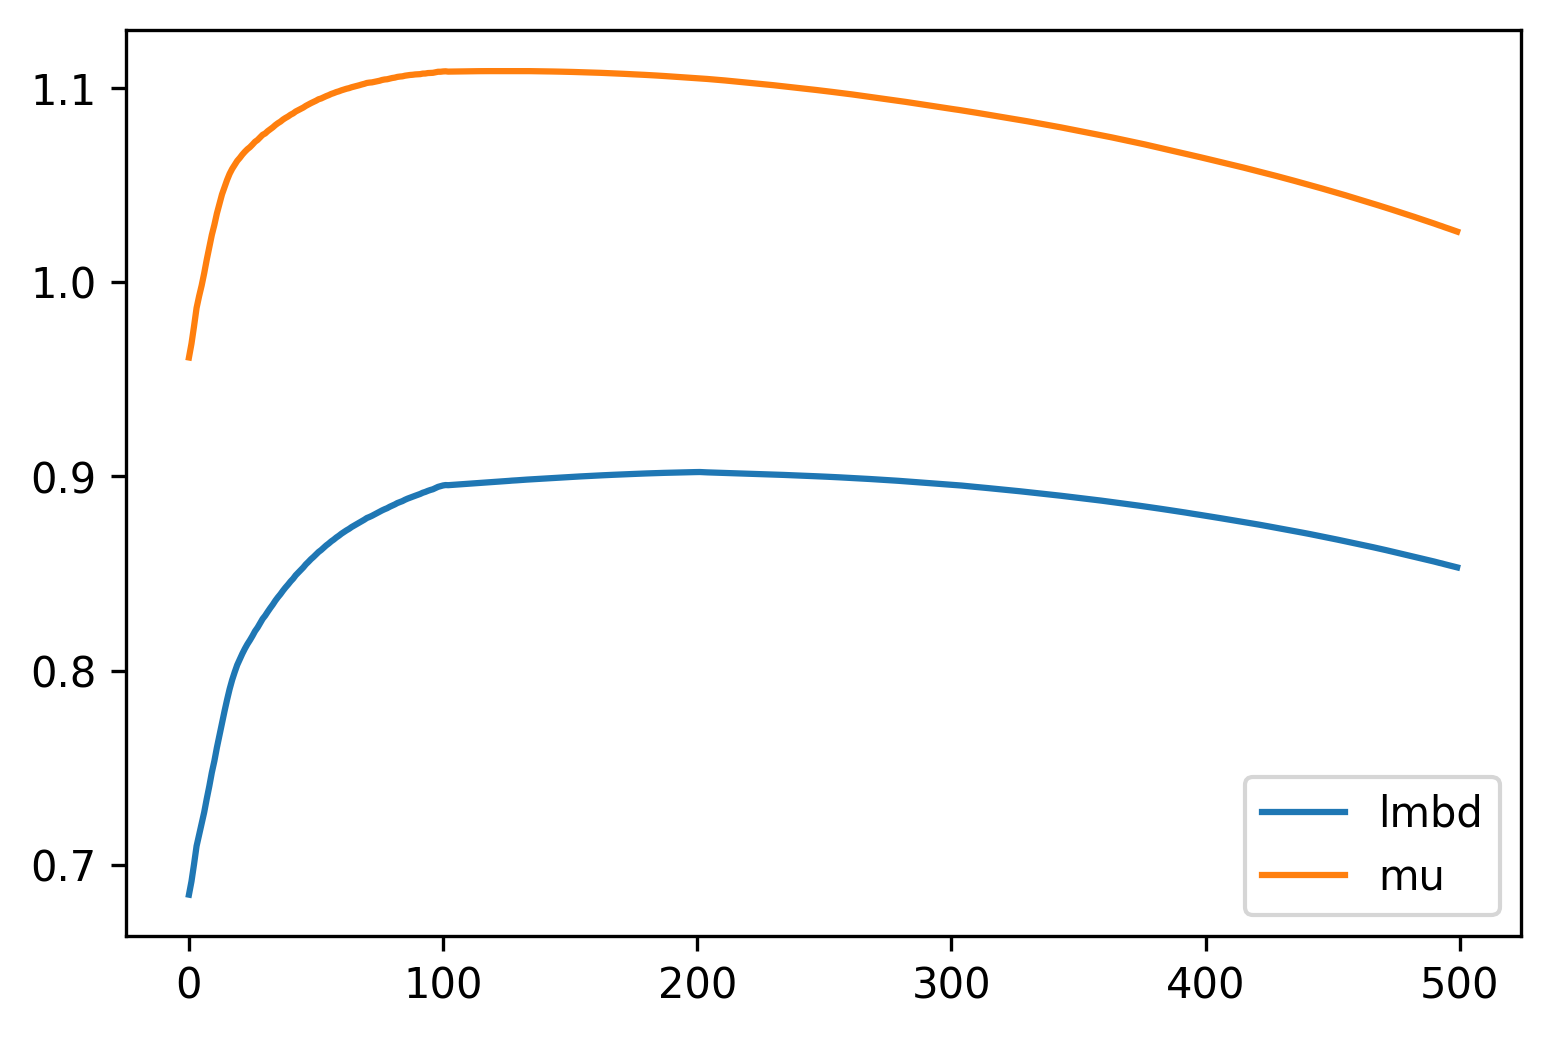

In [ ]:
plt.figure(dpi=300)
plt.plot(h.history['lmbd'], label='lmbd')
plt.plot(h.history['mu'], label='mu')
plt.legend()

$u, v = u_x u_y$ (exact displacement components)


$s_{xx} = \sigma_{xx}$
$s_{yy} = \sigma_{yy}$

In [ ]:
h.history.keys()

dict_keys(['loss', 'sub_19_loss', 'sub_20_loss', 'Uxy_loss', 'Vxy_loss', 'lr', 'time', 'loss_weight_0', 'loss_weight_1', 'loss_weight_2', 'loss_weight_3', 'loss_gradient_0', 'loss_gradient_1', 'loss_gradient_2', 'loss_gradient_3', 'lmbd', 'mu'])

In [ ]:
x_test, y_test = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))

In [ ]:
test_data = {
    'ux': Uxy.eval([x_test, y_test]),
    'uy': Vxy.eval([x_test, y_test]),
    'oxx': Sxx.eval([x_test, y_test]),
    'oyy': Syy.eval([x_test, y_test]),
    'oxy': Sxy.eval([x_test, y_test]),
    'exx': Exx.eval([x_test, y_test]),
    'eyy': Eyy.eval([x_test, y_test]),
    'exy': Exy.eval([x_test, y_test])
}

In [ ]:
u_test = Uxy.eval([x_test, y_test])
v_test = Vxy.eval([x_test, y_test])
sxx_test = Sxx.eval([x_test, y_test])
syy_test = Syy.eval([x_test, y_test])
sxy_test = Sxy.eval([x_test, y_test])
exx_test = Exx.eval([x_test, y_test])
eyy_test = Eyy.eval([x_test, y_test])
exy_test = Exy.eval([x_test, y_test])

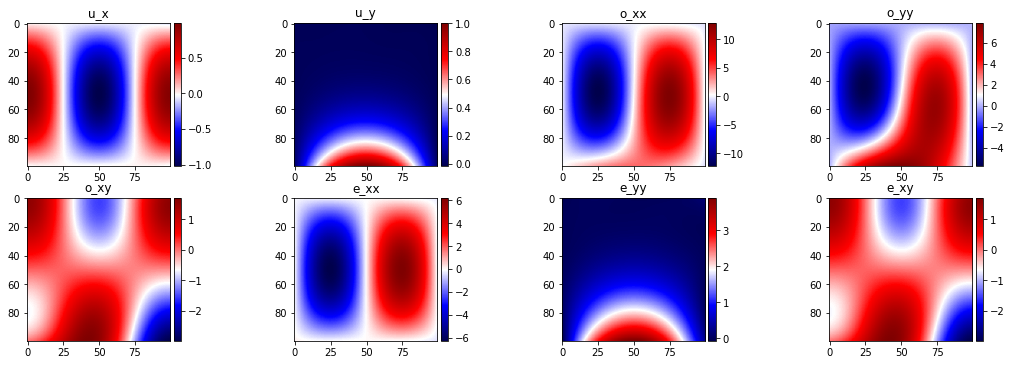

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
tests = [u_test, v_test, sxx_test, syy_test, sxy_test, exx_test, eyy_test, exy_test]
titles = ['u_x', 'u_y', 'o_xx','o_yy','o_xy','e_xx','e_yy','e_xy']
rows, cols = 2,4
fig,ax = plt.subplots(rows,cols,figsize=(15,5))
# ax[0][0].pcolor(x_test, y_test, u_test, cmap='seismic') # u_x displacement in x
# ax[0][1].pcolor(x_test, y_test, v_test, cmap='seismic') # u_y displacement in y
# ax[0][2].pcolor(x_test, y_test, sxx_test, cmap='seismic') # stress tensor - pressure force in xx
# ax[0][3].pcolor(x_test, y_test, syy_test, cmap='seismic') # stress tensor - pressure in yy
# ax[0][4].pcolor(x_test, y_test, sxy_test, cmap='seismic') # stress tensor - shear forces in xy / yx (linear elasticity these are equivalent)
# ax[1][0].pcolor(x_test, y_test, Fx_test, cmap='seismic') # forces in x
# ax[1][1].pcolor(x_test, y_test, Fy_test, cmap='seismic') # forces in y
# ax[1][2].pcolor(x_test, y_test, exx_test, cmap='seismic') # strains in x
# ax[1][3].pcolor(x_test, y_test, eyy_test, cmap='seismic') # strains in y
# ax[1][4].pcolor(x_test, y_test, exy_test, cmap='seismic') # strains in xy

plt.tight_layout(pad=1.05)
n=0
for i in range(rows):
  for j in range(cols):
    ax[i][j].set_aspect('equal')
    ax[i][j].set_title('{}'.format(titles[n]))
    divider = make_axes_locatable(ax[i][j])
    cax = divider.append_axes("right", size="5%", pad = 0.05)
    im = ax[i][j].imshow(tests[n], cmap='seismic')
    plt.colorbar(im, cax = cax)
    n+=1

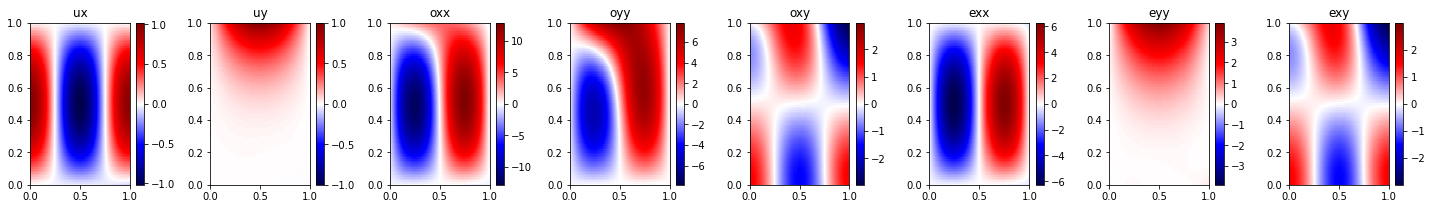

In [ ]:
def cust_plot(ax, val, label):
    im = ax.pcolor(x_test, y_test, val, cmap='seismic',
                   vmin=-np.abs(val).max(), vmax=np.abs(val).max())
    ax.set_title(label)
    plt.colorbar(im, ax=ax)

fig, ax = plt.subplots(1,8,figsize=(20,3))
for i, (key, val) in enumerate(test_data.items()):
    cust_plot(ax[i], val, key)

plt.tight_layout(pad=1.05)
plt.show()

# Viscoelasticity (Maxwell model)

Testing the XYT func - needs 'ics' - in this case two as there needs to be an IC for vertical/horizontal displacement (U/V) (following the example of linear elasticity)

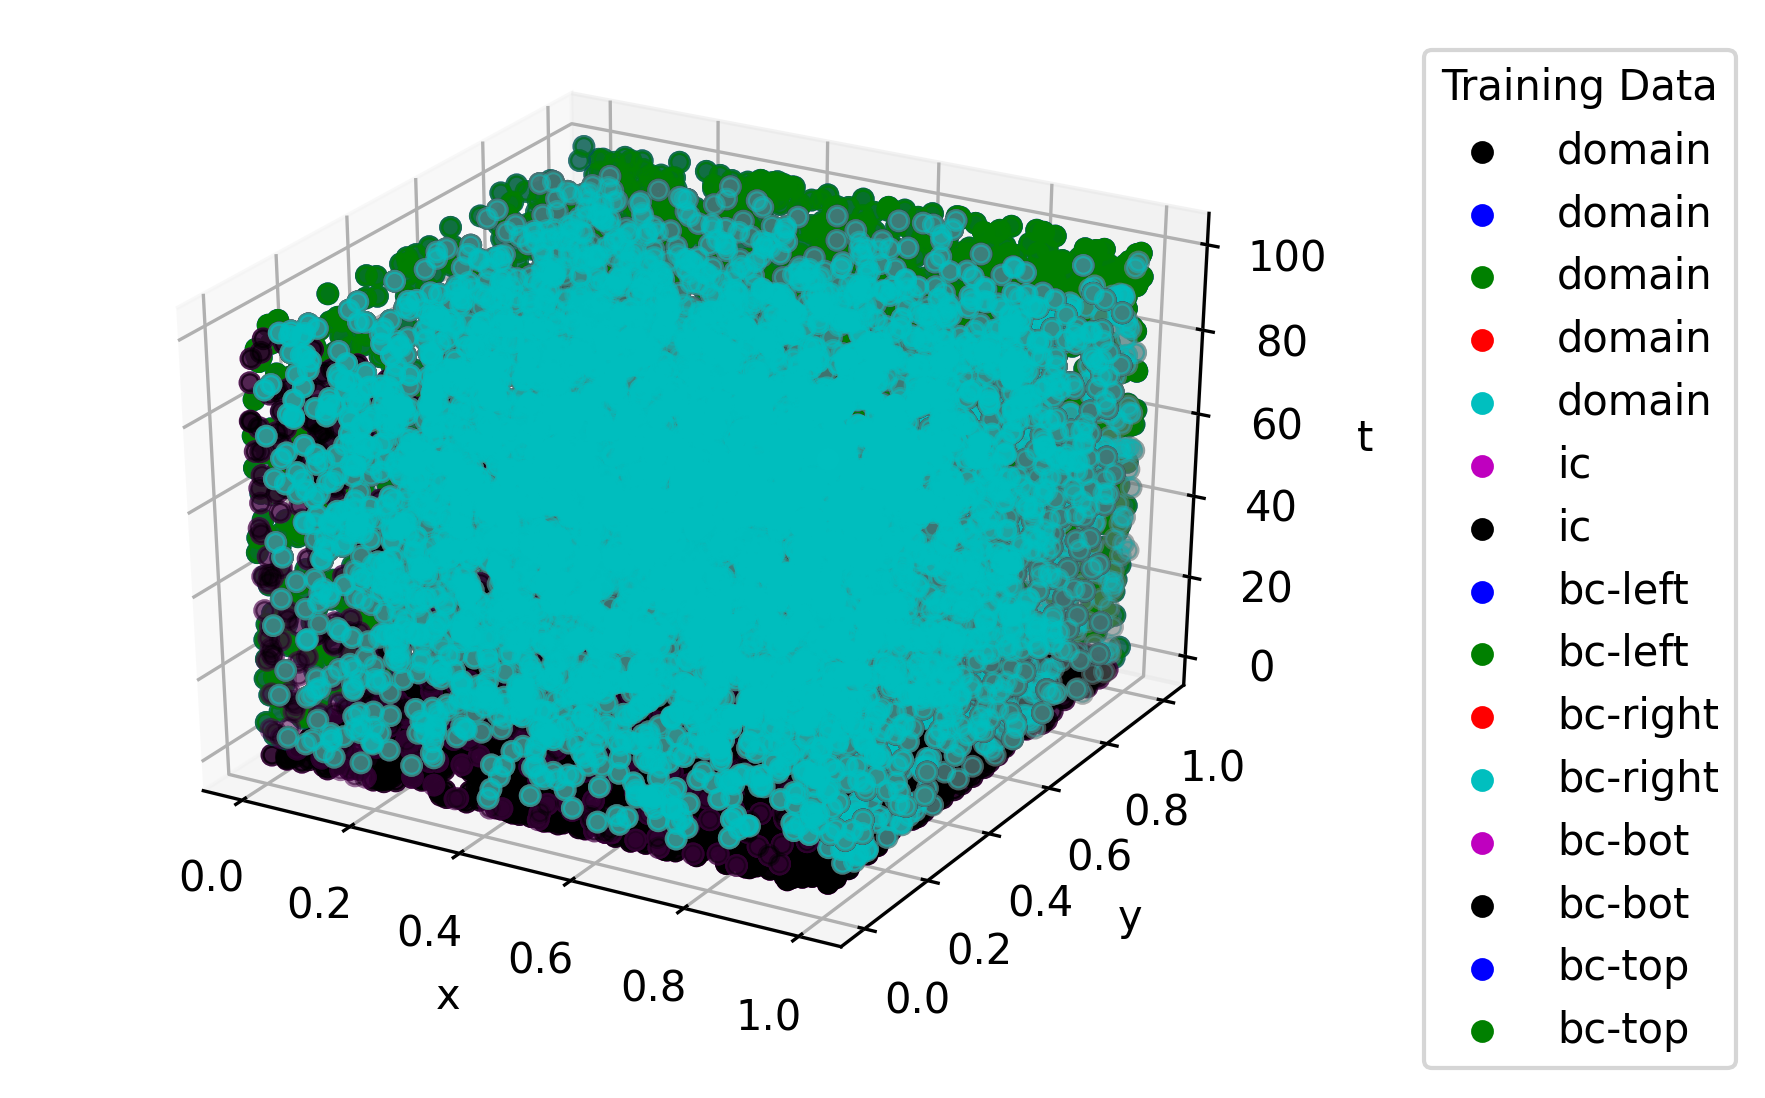

In [ ]:
# *2 on ICs and BCs due to two state vars U and V
dg = DataGeneratorXYT(X=[0.,1.], Y=[0.,1.], T=[0.,100.],
                     num_sample=10000,
                     targets=5*['domain'] + 2*['ic'] + 2*['bc-left'] + 2*['bc-right'] + 2*['bc-bot'] + 2*['bc-top'])

dg.plot_data()

In [ ]:
# # Given both lambda and mu (aka G) we can calculate the other elastic moduli:
# Bulk modulus (K) = lambda + mu
# Youngs modulus (E) = 4*mu ( lambda + mu) / lambda + 2*mu
# poissons ratio (nu) = lambda / lambda + 2*mu
# P-wave modulus(M) = lambda + 2*mu

In [ ]:
# Lame parameters of a homogenous and isotropic material
lmbd = 1.0
# shear modulus
mu = 0.5
# 'we took Q = 4'
Q = 4.0

Constitutive relations from meeting with AGF

$\frac{\eta}{E} \frac{\partial \sigma_{xx}}{\partial t} + \sigma_{xx} = \frac{\eta}{E} (\lambda + 2 \mu) \frac{\partial e_{xx}}{\partial t} + \frac{\eta \lambda}{E} \frac{\partial e_{yy}}{\partial t}$

$\frac{\eta}{E} \frac{\partial \sigma_{yy}}{\partial t} + \sigma_{yy} = \frac{\eta \lambda}{E} \frac{\partial e_{xx}}{\partial t} + \frac{\eta}{E} (\lambda + 2 \mu) \frac{\partial e_{yy}}{\partial t}$

$\frac{\eta}{E} \frac{\partial \sigma_{xy}}{\partial t} + \sigma_{xy} = \frac{2 \eta \mu}{E} \frac{\partial e_{xy}}{\partial t}$



In [ ]:
# Neural Network Setup.
dtype='float32'

x = sn.Variable("x", dtype=dtype)
y = sn.Variable("y", dtype=dtype)
t = sn.Variable("t", dtype=dtype)

# Neural network for the displacement U in x/y
# TODO try increase network size for more accuracy: e.g. 8*[100]
Uxy = sn.Functional("Uxy", [x, y], 4*[40], 'tanh') # 4 hidden layers of 40 size, tanh activation function

# Neural network for the displacement V in x/y
Vxy = sn.Functional("Vxy", [x, y], 4*[40], 'tanh')

#neural networks for the pressure component of the stress
Sxx = sn.Functional("Sxx", [x, y], 4*[40], 'tanh')
Syy = sn.Functional("Syy", [x, y], 4*[40], 'tanh')

# Neural network for the shear forces, in linear elasticity S_xy = S_yx hence just one here
Sxy = sn.Functional("Sxy", [x, y], 4*[40], 'tanh')

# Possibly constitutive relations # TODO change this to a maxwell model
C11 = (2*mu + lmbd) # P-wave/shear modulus?
C12 = lmbd #
C33 = 2*mu #

# strains
Exx = sn.diff(Uxy, x) # discrete differences in Uxy - ASSUMING this is the same as np.diff
Eyy = sn.diff(Vxy, y)
Exy = (sn.diff(Uxy, y) + sn.diff(Vxy, x))*0.5

# Exx = sn.Functional("Exx", [x, y, t], 4*[40], 'tanh')
# Exy = sn.Functional("Exy", [x, y, t], 4*[40], 'tanh')
# Eyy = sn.Functional("Eyy", [x, y, t], 4*[40], 'tanh')

# setting up strain fields as networks (commented code above) i.e. (sn.functionals) doesn't work - keras error to do with specifying outputs of networks - see issue below
# is having the strains initially as derivatives of displacement wrt x or y then differentiating wrt to time acceptable/correct?


dExx_dt = sn.diff(Exx, t)
dExy_dt = sn.diff(Exy, t)
dEyy_dt = sn.diff(Eyy, t)

dSxx_dt = sn.diff(Sxx, t)
dSxy_dt = sn.diff(Sxy, t)
dSyy_dt = sn.diff(Syy, t)

# THIS PAPER SUGGESTS VISCOSITY IS APPROX 2*STRESS https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0052554
eta = 2 # Set to 1 for now for testing
#E = 1 # Set to 1 for now for testing
      # Is this E young's modulus? and if so should it be calculated: # Youngs modulus (E) = 4*mu ( lambda + mu) / lambda + 2*mu
E = 4*mu * (lmbd + mu) / (lmbd + 3*mu)
C = eta/E

# sn.tie constrains networks outputs i.e. ensures cond1 (Sxx) - cond2 (Exx*C11 + Eyy*C12) = 0(?)
c1 = sn.Tie(C*dSxx_dt + Sxx, C*C11*dExx_dt + C*C12 * dEyy_dt)
c2 = sn.Tie(C*dSyy_dt + Syy, C*C12 * dExx_dt + C*C11 * dEyy_dt)
c3 = sn.Tie(C*dSxy_dt + Sxy, C*C33 * dExy_dt)


# Forces acting on the body
Fx = - lmbd*(4*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - mu*(pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - 8*mu*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y)
# Fx = Fx/100
   # equilibrium equations for the stress if you subsitute the constitutive eq
   # so you can write it in terms of the strain - you end up with an equation which you
   # know can be solved by fourier series which involves sins and cosines
# Fy = Fy/100
Fy = lmbd*(3*Q*y**2*sn.sin(pi*x) - 2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x)) \
   - mu*(2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x) + (Q*y**4*pi**2*sn.sin(pi*x))/4) \
   + 6*Q*mu*y**2*sn.sin(pi*x)

# Losses (Momentum relations?)
Lx = sn.diff(Sxx, x) + sn.diff(Sxy, y) - Fx # do_xx/dx + do_xy/dy + f_x = 0
Ly = sn.diff(Sxy, x) + sn.diff(Syy, y) - Fy # do_xy/dx + doyy/dy + f_y = 0

BC_left_1 = (x==0.)*(Vxy) # vertical displacement = 0
BC_left_2 = (x==0.)*Sxx #o_xx is 0 here as well

# V/U xy is V/U AT x/y

BC_right_1 = (x==1.)*(Vxy) # same as for left
BC_right_2 = (x==1.)*Sxx

BC_bot_1 = (y==0.)*(Uxy) #fixed boundary condition
BC_bot_2 = (y==0.)*(Vxy) #no horizontal or vertical displacement

BC_top_1 = (y==1.)*(Uxy) #fixed in horizontal
BC_top_2 = (y==1.)*(Syy - (lmbd+2*mu)*Q*sn.sin(pi*x)) #fixed stress boundary cd

ic1 = sn.Functional("ic1", [x, y], 4*[40], 'tanh')
ic2 = sn.Functional("ic2", [x, y], 4*[40], 'tanh')
# collecting the losses

targets = [Lx, Ly, c1, c2, c3, ic1, ic2,
           BC_left_1, BC_left_2,
           BC_right_1, BC_right_2,
           BC_bot_1, BC_bot_2,
           BC_top_1, BC_top_2]

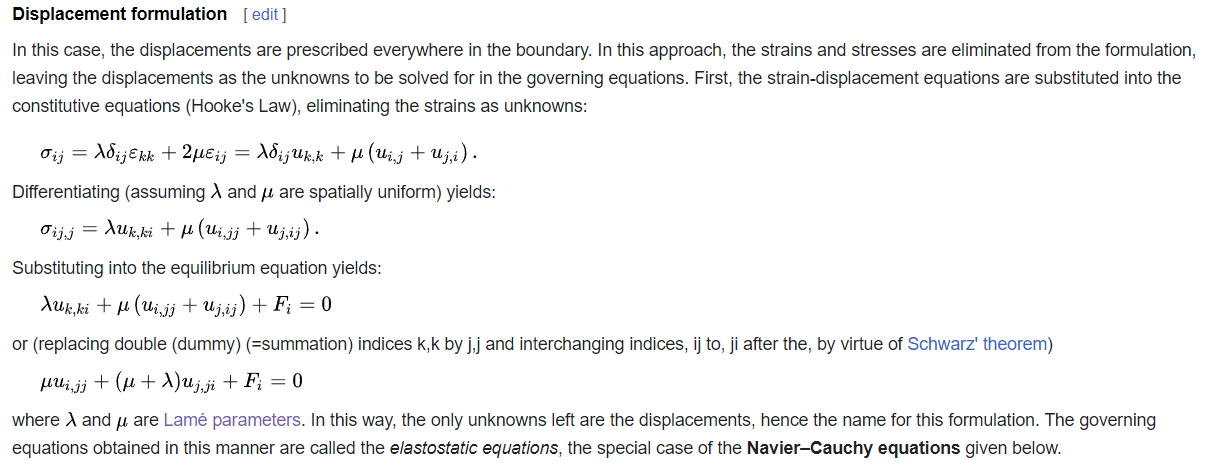

In [ ]:
dg = DataGeneratorXYT(X=[0.,1.], Y=[0.,1.], T=[0.,100.],
                     num_sample=10000,
                     targets=5*['domain'] + 2*['ic'] + 2*['bc-left'] + 2*['bc-right'] + 2*['bc-bot'] + 2*['bc-top'])

# 5 domain targets = Lx, Ly, c1, c2, c3
# 2 ic targets set up as trainable networks (not sure if this is correct - need to also
# try sn.variable(), I tried this as BCs are set up at a constant multiplied by sn.Functional (e.g. Uxy) which returns a network)

input_data, target_data = dg.get_data()


In [ ]:
m = sn.SciModel([x, y, t], targets)

In [ ]:
m.train(input_data, target_data, batch_size=100, epochs=100)


Total samples: 11250 
Batch size: 100 
Total batches: 113 

Epoch 1/100
113/113 [==============================] - 13s 28ms/step - batch: 56.0000 - size: 99.5575 - loss: 1570.0528 - sub_106_loss: 1370.3153 - sub_107_loss: 175.4439 - sub_97_loss: 4.5321 - sub_98_loss: 5.7413 - sub_99_loss: 1.2745 - ic1_loss: 0.0022 - ic2_loss: 0.0066 - mul_539_loss: 0.0015 - mul_540_loss: 0.6139 - mul_541_loss: 0.0056 - mul_542_loss: 1.8567 - mul_543_loss: 0.0119 - mul_544_loss: 0.0029 - mul_545_loss: 0.0440 - mul_548_loss: 10.2068 - lr: 0.0010 - time: 13.2085
Epoch 2/100
113/113 [==============================] - 2s 20ms/step - batch: 56.0000 - size: 99.5575 - loss: 549.2776 - sub_106_loss: 458.8475 - sub_107_loss: 33.3907 - sub_97_loss: 20.7444 - sub_98_loss: 4.6995 - sub_99_loss: 9.0956 - ic1_loss: 7.0168e-06 - ic2_loss: 9.4229e-05 - mul_539_loss: 2.8502e-06 - mul_540_loss: 2.3039 - mul_541_loss: 1.6955e-05 - mul_542_loss: 13.0172 - mul_543_loss: 2.5564e-05 - mul_544_loss: 4.4061e-06 - mul_545_loss:

# Useful links
These related to a bug I was having with keras related to some of the gradients of the networks being None type, which was because I wasn't specifying their targets - leaving here in case it's useful in the future though.

https://github.com/sciann/sciann/issues/11

Try also reading carefully: https://github.com/sciann/sciann-applications/tree/master/SciANN-DataGenerator

# Testing the trained networks

In [ ]:
x_test, y_test = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
t_test = np.linspace(0,1,100)

In [ ]:

u_test = Uxy.eval([x_test, y_test])
v_test = Vxy.eval([x_test, y_test])
sxx_test = Sxx.eval([x_test, y_test])
syy_test = Syy.eval([x_test, y_test])
sxy_test = Sxy.eval([x_test, y_test])

Fx_test = Fx.eval([x_test, y_test])
Fy_test = Fy.eval([x_test, y_test])
exx_test = Exx.eval([x_test, y_test])
eyy_test = Eyy.eval([x_test, y_test])
exy_test = Exy.eval([x_test, y_test])

dSxx_test = dSxx_dt.eval([x_test, y_test, t_test])
dSxy_test = dSxy_dt.eval([x_test, y_test, t_test])
dSyy_test = dSyy_dt.eval([x_test, y_test, t_test])

dExx_dt_test = dExx_dt.eval([x_test, y_test, t_test])
dExy_dt_test = dExy_dt.eval([x_test, y_test, t_test])
dEyy_dt_test = dEyy_dt.eval([x_test, y_test, t_test])

# probably don't need the derivative fields(?) for plotting - doesn't make sense?

Not sure if above is right - as surely Exx etc. should need some t_test input to predict a strain field? Unless this is predicting at t_end or something. All the d/dt networks need t_test as an input (as this is how the input data is defined in the creation of the network with sn.Tie())

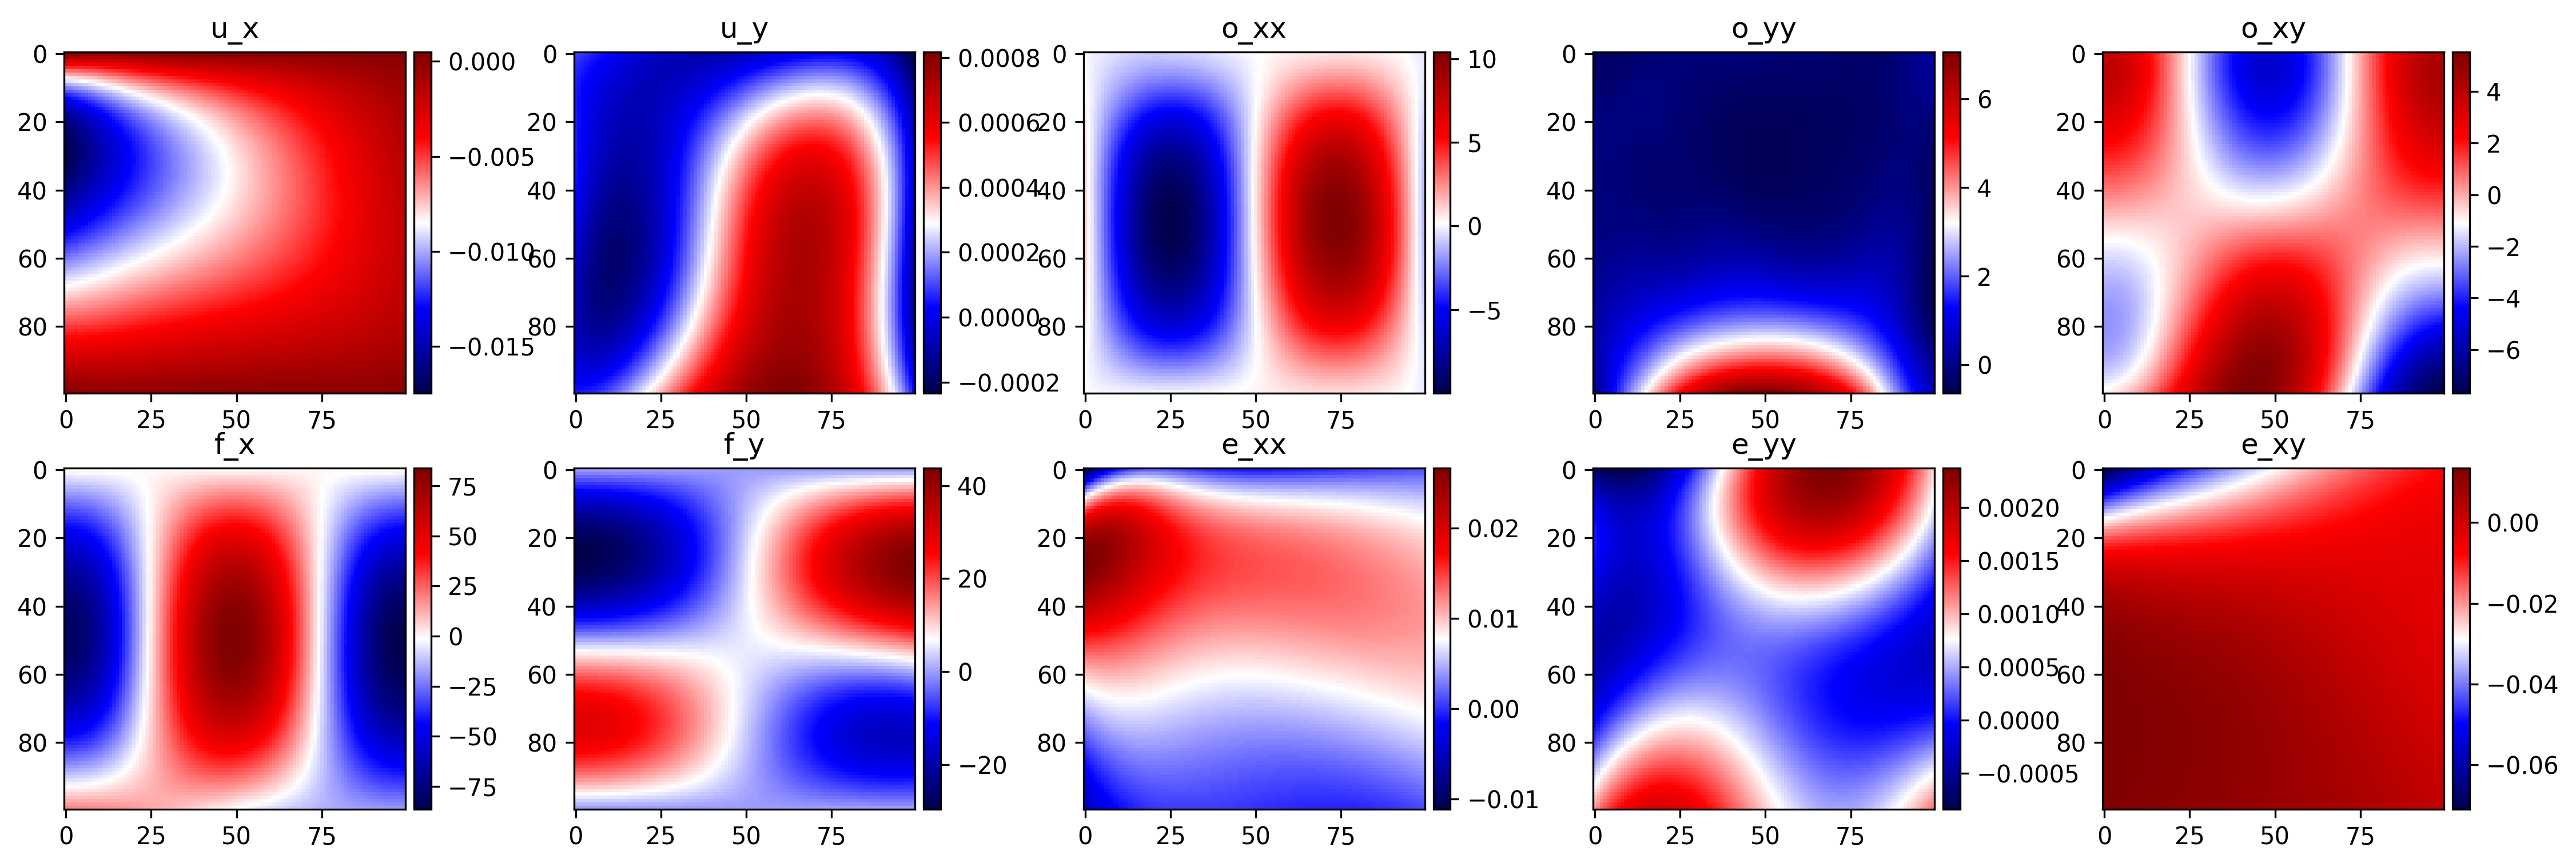

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
tests = [u_test, v_test, sxx_test, syy_test, sxy_test, Fx_test, Fy_test, exx_test, eyy_test, exy_test]
titles = ['u_x', 'u_y', 'o_xx','o_yy','o_xy','f_x','f_y', 'e_xx','e_yy','e_xy']
rows, cols = 2,5
fig,ax = plt.subplots(rows,cols,figsize=(15,5))


plt.tight_layout(pad=1.05)
n=0
for i in range(rows):
  for j in range(cols):
    ax[i][j].set_aspect('equal')
    ax[i][j].set_title('{}'.format(titles[n]))
    divider = make_axes_locatable(ax[i][j])
    cax = divider.append_axes("right", size="5%", pad = 0.05)
    im = ax[i][j].imshow(tests[n], cmap='seismic')
    plt.colorbar(im, cax = cax)
    n+=1

Linear elasticity results below - it's different to above at least... Similarities in stress components may be because I set eta/E to 1

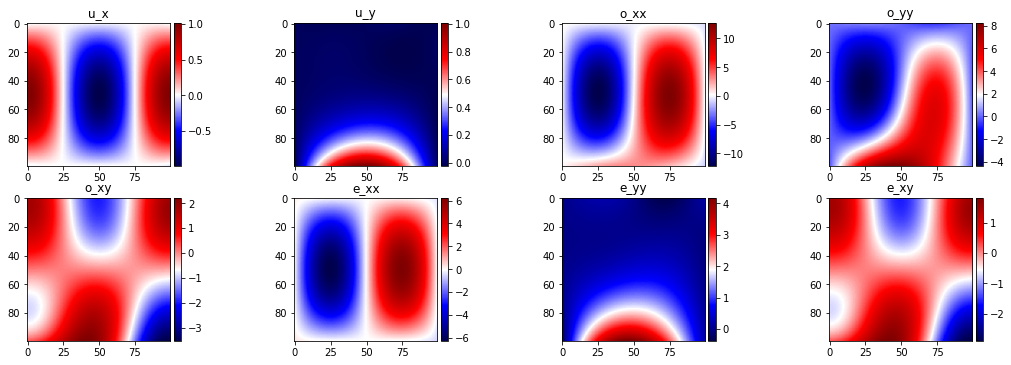

# Viscoelasticity inverse

First comment out the stresses - these will be inferred from strains

TODO figure our the momentum relation

In [ ]:
Q = 4

In [ ]:
# Neural Network Setup.
dtype='float32'

x = sn.Variable("x", dtype=dtype)
y = sn.Variable("y", dtype=dtype)
t = sn.Variable("t", dtype=dtype)

# Neural network for the displacement U in x/y
# TODO try increase network size for more accuracy: e.g. 8*[100]
Uxy = sn.Functional("Uxy", [x, y], 4*[40], 'tanh') # 4 hidden layers of 40 size, tanh activation function

# Neural network for the displacement V in x/y
Vxy = sn.Functional("Vxy", [x, y], 4*[40], 'tanh')

# #neural networks for the pressure component of the stress
# Sxx = sn.Functional("Sxx", [x, y], 4*[40], 'tanh')
# Syy = sn.Functional("Syy", [x, y], 4*[40], 'tanh')

# # Neural network for the shear forces, in linear elasticity S_xy = S_yx hence just one here
# Sxy = sn.Functional("Sxy", [x, y], 4*[40], 'tanh')

lmbd = sn.Parameter(np.random.rand(), name='lmbd', inputs=[x,y])
mu = sn.Parameter(np.random.rand(), name='mu', inputs=[x,y])
eta = sn.Parameter(np.random.rand(), name='eta', inputs=[x,y])
E = sn.Parameter(np.random.rand(), name='E', inputs=[x,y])

# lmbd = sn.Parameter(1, name='lmbd', inputs=[x,y])
# mu = sn.Parameter(1, name='mu', inputs=[x,y])
# # eta = sn.Parameter(1, name='eta', inputs=[x,y])
# E = sn.Parameter(2, name='E', inputs=[x,y])

# Possibly constitutive relations # TODO change this to a maxwell model
C11 = (2*mu + lmbd) # P-wave/shear modulus?
C12 = lmbd #
C33 = 2*mu #
C = eta/E

# # Possibly constitutive relations # TODO change this to a maxwell model
# C11 = (2*eta + E) # P-wave/shear modulus?
# C12 = eta #
# C33 = 2*E #
# C = eta/E


# strains
Exx = sn.diff(Uxy, x) # discrete differences in Uxy - ASSUMING this is the same as np.diff
Eyy = sn.diff(Vxy, y)
Exy = (sn.diff(Uxy, y) + sn.diff(Vxy, x))*0.5

dExx_dt = sn.diff(Exx, t)
dExy_dt = sn.diff(Exy, t)
dEyy_dt = sn.diff(Eyy, t)

Sxx= Exx*C11 + Eyy*C12
Syy= Eyy*C11 + Exx*C12
Sxy= Exy*C33

dSxx_dt = sn.diff(Sxx, t)
dSxy_dt = sn.diff(Sxy, t)
dSyy_dt = sn.diff(Syy, t)

Sxx = C*C11*dExx_dt + C*C12 * dEyy_dt - C*dSxx_dt
Syy = C*C12 * dExx_dt + C*C11 * dEyy_dt - C*dSyy_dt
Sxy = C*C33 * dExy_dt - C*dSxy_dt

# Forces acting on the body
Fx = - lmbd*eta/E*(4*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - mu*(pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - 8*mu*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) #+ E*4 - eta*3

Fy = lmbd*eta/E*(3*Q*y**2*sn.sin(pi*x) - 2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x)) \
   - mu*(2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x) + (Q*y**4*pi**2*sn.sin(pi*x))/4) \
   + 6*Q*mu*y**2*sn.sin(pi*x) #- eta * E

#################
#Parameters only get optimised when they are part of Fx or Fy e.g. E / eta above
#################


# Losses (Momentum relations)
Lx = sn.diff(Sxx, x) + sn.diff(Sxy, y) - Fx # do_xx/dx + do_xy/dy + f_x = 0
Ly = sn.diff(Sxy, x) + sn.diff(Syy, y) - Fy # do_xy/dx + doyy/dy + f_y = 0

# sn.Data
Du = sn.Data(Uxy)
Dv = sn.Data(Vxy)

# DSxx = sn.Data(Sxx)
# DSxy = sn.Data(Sxy)
# DSyy = sn.Data(Syy)
targets = [Lx, Ly, Du, Dv]
#targets = [Lx, Ly, Du, Dv, DSxx, DSxy, DSyy]

Need to discuss with Alex how to incorporate eta/E into the Losses

In [ ]:
m = sn.SciModel([x, y, t], targets)

In [ ]:
#generate data - collocation?
x_data, y_data, t_data = np.meshgrid(np.linspace(0.,1.,20), np.linspace(0., 1., 20), np.linspace(0., 1., 20))

#prescribed displacement everywhere (including at the boundary)
u_data = np.cos(2*pi*x_data) * np.sin(pi*y_data)
v_data = np.sin(pi*x_data) * Q * y_data**4/4
# syy_data = 2*Q*np.sin(pi*y_data)*(y_data==1.)

Lx_data = np.zeros_like(x_data)
Ly_data = np.zeros_like(y_data)

# DSxx_data = np.zeros_like(x_data)
# DSxy_data = np.zeros_like(x_data)
# DSyy_data = np.zeros_like(y_data)

DSxx_data = np.full_like(x_data, x_data)
DSxy_data = np.full_like(x_data, x_data)
DSyy_data = np.full_like(y_data, x_data)


c1_data = np.zeros_like(y_data)
c2_data = np.zeros_like(y_data)
c3_data = np.zeros_like(y_data)


In [ ]:
h = m.train([x_data, y_data, t_data], [Lx_data, Ly_data, u_data, v_data], #syy_data],
            batch_size=50, epochs=2500, log_parameters={'parameters':[lmbd, mu, eta, E], 'freq':1},
            adaptive_weights={'method':'NTK', 'freq': 100})
# h = m.train([x_data, y_data, t_data], [Lx_data, Ly_data, u_data, v_data, DSxx_data, DSxy_data, DSyy_data], #syy_data],
#             batch_size=50, epochs=2500, log_parameters={'parameters':[lmbd, mu, eta, E], 'freq':1},
#             adaptive_weights={'method':'NTK', 'freq': 100})


Total samples: 8000 
Batch size: 50 
Total batches: 160 


+ NTK evaluation time [s]: 3.1041574478149414 

+ adaptive_weights at epoch 1: [0.10000011003660614, 0.1000006717855618, 2.3497086646776975, 1.450290553500135]
Epoch 1/2500
160/160 [==============================] - 12s 27ms/step - batch: 79.5000 - size: 50.0000 - loss: 3225.8971 - sub_129_loss: 26489.4375 - sub_130_loss: 5765.6597 - Uxy_loss: 0.1523 - Vxy_loss: 0.0156 - lr: 0.0010 - time: 24.8117 - loss_weight_0: 0.1000 - loss_weight_1: 0.1000 - loss_weight_2: 2.3497 - loss_weight_3: 1.4503 - loss_gradient_0: 4885538420.3069 - loss_gradient_1: 890591463.7206 - loss_gradient_2: 176.6579 - loss_gradient_3: 295.7501 - lmbd: 0.6085 - mu: 0.7308 - eta: 0.3563 - E: 0.0596
Epoch 2/2500
160/160 [==============================] - 2s 16ms/step - batch: 79.5000 - size: 50.0000 - loss: 965.5253 - sub_129_loss: 8126.3828 - sub_130_loss: 1527.3064 - Uxy_loss: 0.0627 - Vxy_loss: 0.0051 - lr: 0.0010 - time: 2.4673 - loss_weight_0: 0.1000 - l

KeyboardInterrupt: ignored

# Linear Voigt

Testing the XYT func - needs 'ics' - in this case two as there needs to be an IC for vertical/horizontal displacement (U/V) (following the example of linear elasticity)

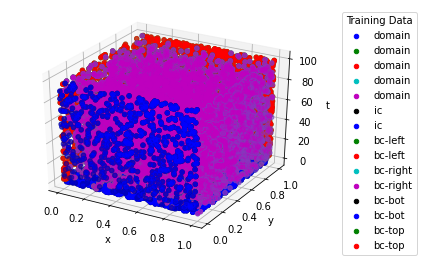

In [ ]:
# *2 on ICs and BCs due to two state vars U and V
dg = DataGeneratorXYT(X=[0.,1.], Y=[0.,1.], T=[0.,100.],
                     num_sample=10000,
                     targets=5*['domain'] + 2*['ic'] + 2*['bc-left'] + 2*['bc-right'] + 2*['bc-bot'] + 2*['bc-top'])

dg.plot_data()

In [ ]:
# # Given both lambda and mu (aka G) we can calculate the other elastic moduli:
# Bulk modulus (K) = lambda + mu
# Youngs modulus (E) = 4*mu ( lambda + mu) / lambda + 2*mu
# poissons ratio (nu) = lambda / lambda + 2*mu
# P-wave modulus(M) = lambda + 2*mu

In [ ]:
# Lame parameters of a homogenous and isotropic material
lmbd = 1.0
# shear modulus
mu = 0.5
# 'we took Q = 4'
Q = 4.0

Constitutive relations from AGF whiteboard

$ \sigma_{xx} = (\lambda + 2\mu) e_{xx} + \frac{\eta}{\mu} (\lambda + 2\mu) \frac{\partial e_{xx}}{\partial t} + \lambda e_{yy} + \frac{\eta \lambda}{\mu} + \frac{\partial e_{yy}}{\partial t}$

$ \sigma_{yy} =  (\lambda + 2\mu) e_{yy} + \lambda e_{xx} + \frac{\eta}{\mu} (\lambda + 2 \mu) \frac{\partial e_{yy}}{\partial t} + \frac{\eta \lambda}{\mu} \frac{\partial e_{xx}}{\partial t}$

$\sigma_{xy} = 2 \mu e_{xy} + 2 \eta \frac{\partial e_{xy}}{\partial t}$



In [ ]:
# Neural Network Setup.
dtype='float32'

x = sn.Variable("x", dtype=dtype)
y = sn.Variable("y", dtype=dtype)
t = sn.Variable("t", dtype=dtype)

# Neural network for the displacement U in x/y
# TODO try increase network size for more accuracy: e.g. 8*[100]
Uxy = sn.Functional("Uxy", [x, y], 4*[40], 'tanh') # 4 hidden layers of 40 size, tanh activation function

# Neural network for the displacement V in x/y
Vxy = sn.Functional("Vxy", [x, y], 4*[40], 'tanh')

#neural networks for the pressure component of the stress
Sxx = sn.Functional("Sxx", [x, y], 4*[40], 'tanh')
Syy = sn.Functional("Syy", [x, y], 4*[40], 'tanh')

# Neural network for the shear forces, in linear elasticity S_xy = S_yx hence just one here
Sxy = sn.Functional("Sxy", [x, y], 4*[40], 'tanh')

# Possibly constitutive relations # TODO change this to a maxwell model
C11 = (2*mu + lmbd) # P-wave/shear modulus?
C12 = lmbd #
C33 = 2*mu #

eta = 1 # Set to 1 for now for testing
E = 1 # Set to 1 for now for testing
      # Is this E young's modulus? and if so should it be calculated: # Youngs modulus (E) = 4*mu ( lambda + mu) / lambda + 2*mu

C = eta/mu

# strains
Exx = sn.diff(Uxy, x) # discrete differences in Uxy - ASSUMING this is the same as np.diff
Eyy = sn.diff(Vxy, y)
Exy = (sn.diff(Uxy, y) + sn.diff(Vxy, x))*0.5

# Exx = sn.Functional("Exx", [x, y, t], 4*[40], 'tanh')
# Exy = sn.Functional("Exy", [x, y, t], 4*[40], 'tanh')
# Eyy = sn.Functional("Eyy", [x, y, t], 4*[40], 'tanh')

# setting up strain fields as networks (commented code above) i.e. (sn.functionals) doesn't work - keras error to do with specifying outputs of networks - see issue below
# is having the strains initially as derivatives of displacement wrt x or y then differentiating wrt to time acceptable/correct?


dExx_dt = sn.diff(Exx, t)
dExy_dt = sn.diff(Exy, t)
dEyy_dt = sn.diff(Eyy, t)

dSxx_dt = sn.diff(Sxx, t)
dSxy_dt = sn.diff(Sxy, t)
dSyy_dt = sn.diff(Syy, t)



# sn.tie constrains networks outputs i.e. ensures cond1 (Sxx) - cond2 (Exx*C11 + Eyy*C12) = 0(?)

c1 = sn.Tie(Sxx, C11 * Exx + eta/mu * C11 * dExx_dt + C12 * Eyy + eta/mu * C12 + dEyy_dt)
c2 = sn.Tie(Syy, C11 * Eyy + C12 * Exx + eta/mu * C11 * dEyy_dt + eta/mu * C12 * dExx_dt)
c3 = sn.Tie(Sxy, C33 * Exy + 2* eta * dExy_dt)


# Forces acting on the body
Fx = - lmbd*(4*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - mu*(pi**2*sn.cos(2*pi*x)*sn.sin(pi*y) - Q*y**3*pi*sn.cos(pi*x)) \
   - 8*mu*pi**2*sn.cos(2*pi*x)*sn.sin(pi*y)

   # equilibrium equations for the stress if you subsitute the constitutive eq
   # so you can write it in terms of the strain - you end up with an equation which you
   # know can be solved by fourier series which involves sins and cosines

Fy = lmbd*(3*Q*y**2*sn.sin(pi*x) - 2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x)) \
   - mu*(2*pi**2*sn.cos(pi*y)*sn.sin(2*pi*x) + (Q*y**4*pi**2*sn.sin(pi*x))/4) \
   + 6*Q*mu*y**2*sn.sin(pi*x)

# Losses (Momentum relations?)
Lx = sn.diff(Sxx, x) + sn.diff(Sxy, y) - Fx # do_xx/dx + do_xy/dy + f_x = 0
Ly = sn.diff(Sxy, x) + sn.diff(Syy, y) - Fy # do_xy/dx + doyy/dy + f_y = 0

BC_left_1 = (x==0.)*(Vxy) # vertical displacement = 0
BC_left_2 = (x==0.)*Sxx #o_xx is 0 here as well

# V/U xy is V/U AT x/y

BC_right_1 = (x==1.)*(Vxy) # same as for left
BC_right_2 = (x==1.)*Sxx

BC_bot_1 = (y==0.)*(Uxy) #fixed boundary condition
BC_bot_2 = (y==0.)*(Vxy) #no horizontal or vertical displacement

BC_top_1 = (y==1.)*(Uxy) #fixed in horizontal
BC_top_2 = (y==1.)*(Syy - (lmbd+2*mu)*Q*sn.sin(pi*x)) #fixed stress boundary cd

ic1 = sn.Functional("ic1", [x, y], 4*[40], 'tanh')
ic2 = sn.Functional("ic2", [x, y], 4*[40], 'tanh')
# collecting the losses

targets = [Lx, Ly, c1, c2, c3, ic1, ic2,
           BC_left_1, BC_left_2,
           BC_right_1, BC_right_2,
           BC_bot_1, BC_bot_2,
           BC_top_1, BC_top_2]

In [ ]:
dg = DataGeneratorXYT(X=[0.,1.], Y=[0.,1.], T=[0.,100.],
                     num_sample=10000,
                     targets=5*['domain'] + 2*['ic'] + 2*['bc-left'] + 2*['bc-right'] + 2*['bc-bot'] + 2*['bc-top'])

# 5 domain targets = Lx, Ly, c1, c2, c3
# 2 ic targets set up as trainable networks (not sure if this is correct - need to also
# try sn.variable(), I tried this as BCs are set up at a constant multiplied by sn.Functional (e.g. Uxy) which returns a network)

input_data, target_data = dg.get_data()


In [ ]:
m = sn.SciModel([x, y, t], targets)

In [ ]:
m.train(input_data, target_data, batch_size=100, epochs=1000)


Total samples: 11250 
Batch size: 100 
Total batches: 113 

Epoch 1/1000
113/113 [==============================] - 3s 23ms/step - batch: 56.0000 - size: 99.5575 - loss: 13.4338 - sub_10_loss: 8.0360 - sub_11_loss: 1.8153 - sub_loss: 1.2909 - sub_2_loss: 0.6574 - sub_3_loss: 0.1447 - ic1_loss: 5.0722e-04 - ic2_loss: 0.0017 - mul_53_loss: 0.0296 - mul_54_loss: 0.1817 - mul_55_loss: 0.0146 - mul_56_loss: 0.9011 - mul_57_loss: 0.0169 - mul_58_loss: 0.0111 - mul_59_loss: 0.0306 - mul_62_loss: 0.3010 - lr: 0.0010 - time: 2.6388
Epoch 2/1000
113/113 [==============================] - 2s 22ms/step - batch: 56.0000 - size: 99.5575 - loss: 0.2728 - sub_10_loss: 0.1033 - sub_11_loss: 0.0522 - sub_loss: 0.0390 - sub_2_loss: 0.0240 - sub_3_loss: 0.0150 - ic1_loss: 3.9708e-07 - ic2_loss: 9.3590e-07 - mul_53_loss: 0.0052 - mul_54_loss: 0.0037 - mul_55_loss: 0.0025 - mul_56_loss: 0.0083 - mul_57_loss: 0.0039 - mul_58_loss: 0.0027 - mul_59_loss: 0.0045 - mul_62_loss: 0.0085 - lr: 0.0010 - time: 2.458

## Testing the trained networks

In [ ]:
x_test, y_test = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
t_test = np.linspace(0,1,100)

In [ ]:
u_test = Uxy.eval([x_test, y_test])
v_test = Vxy.eval([x_test, y_test])
sxx_test = Sxx.eval([x_test, y_test])
syy_test = Syy.eval([x_test, y_test])
sxy_test = Sxy.eval([x_test, y_test])

Fx_test = Fx.eval([x_test, y_test])
Fy_test = Fy.eval([x_test, y_test])
exx_test = Exx.eval([x_test, y_test])
eyy_test = Eyy.eval([x_test, y_test])
exy_test = Exy.eval([x_test, y_test])

dSxx_test = dSxx_dt.eval([x_test, y_test, t_test])
dSxy_test = dSxy_dt.eval([x_test, y_test, t_test])
dSyy_test = dSyy_dt.eval([x_test, y_test, t_test])

dExx_dt_test = dExx_dt.eval([x_test, y_test, t_test])
dExy_dt_test = dExy_dt.eval([x_test, y_test, t_test])
dEyy_dt_test = dEyy_dt.eval([x_test, y_test, t_test])

# probably don't need the derivative fields(?) for plotting - doesn't make sense?

Not sure if above is right - as surely Exx etc. should need some t_test input to predict a strain field? Unless this is predicting at t_end or something. All the d/dt networks need t_test as an input (as this is how the input data is defined in the creation of the network with sn.Tie())

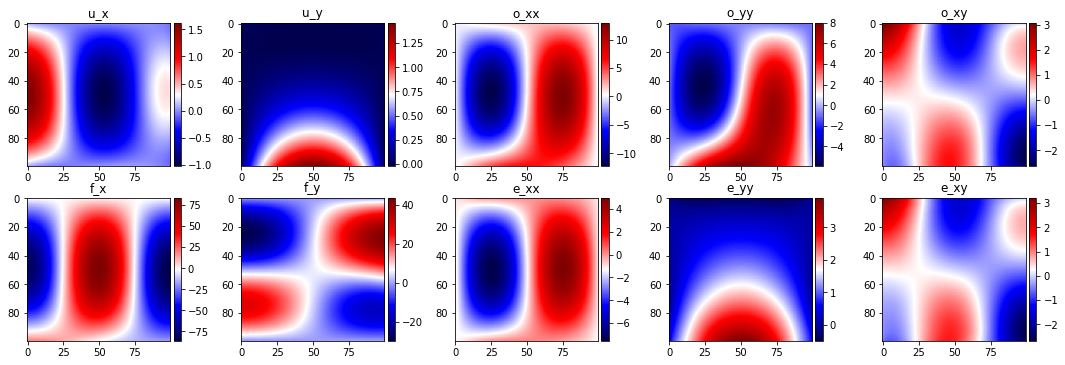

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
tests = [u_test, v_test, sxx_test, syy_test, sxy_test, Fx_test, Fy_test, exx_test, eyy_test, exy_test]
titles = ['u_x', 'u_y', 'o_xx','o_yy','o_xy','f_x','f_y', 'e_xx','e_yy','e_xy']
rows, cols = 2,5
fig,ax = plt.subplots(rows,cols,figsize=(15,5))


plt.tight_layout(pad=1.05)
n=0
for i in range(rows):
  for j in range(cols):
    ax[i][j].set_aspect('equal')
    ax[i][j].set_title('{}'.format(titles[n]))
    divider = make_axes_locatable(ax[i][j])
    cax = divider.append_axes("right", size="5%", pad = 0.05)
    im = ax[i][j].imshow(tests[n], cmap='seismic')
    plt.colorbar(im, cax = cax)
    n+=1

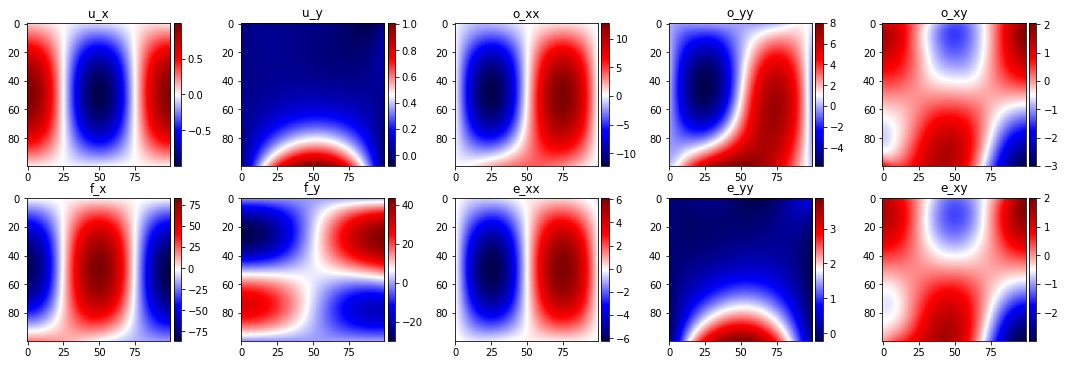